**Project - SVM, Decision Tree, Boosting and Bagging Machine learning algorithms**  
_Adityan Rajendran_

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Confusion Matrix plotting function definition
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    if not title:
        title = 'Confusion matrix for best model'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #return ax

    fig2 = plt.figure(figsize=(10, 2))
    ax2 = plt.subplot(111)
    ax2.axis('off')

    colLabels1 = ['Metrics','Values']
    cellText1 = [['Accuracy', round((cm[0,0] + cm[1,1])/sum(cm[0]+cm[1]),4)],
            ['Recall',round(((cm[0,0])/sum(cm[0])),4)],
            ['Precision',round((cm[0,0]/(cm[0,0]+cm[1,0])),4)]]
    colColours1 = ['#56b5fd','lightgray']
    rowColours1 = [['lightgray','w'],['lightgray','w'],['lightgray','w']]
    tab = ax2.table(cellText=cellText1, colLabels=colLabels1, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours1, colColours=colColours1)
    #tab = ax2.table(cellText=cellText1, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours1, colColours=colColours1)
    tab.auto_set_font_size(False)
    tab.set_fontsize(14)
    return ax,ax2

**Dataset 1 - EDA and Pre-processing**

In [4]:
## Dataset 1 - Energy data
# Converting 'Energy' dataset into binary classification problem
energy_data = pd.read_csv('energydata_complete.csv')
energy_data.drop(['date','rv1','rv2'], axis = 1, inplace = True) ##Dropping date column as it is not needed

# Coverting to binary classification
target_col = 'Appliances'
for i in range(len(energy_data)):
    if(energy_data['Appliances'].values[i] <= 60):
        energy_data['Appliances'].values[i] = 0
    else:
        energy_data['Appliances'].values[i] = 1

dt_data = energy_data.copy(deep=True)

# Feature scaling - Mean normalization
for col in energy_data.columns:
    if(col != 'Appliances'):
        energy_data[col] = (energy_data[col] - energy_data[col].mean())/energy_data[col].std()
        
# Train test split       
from sklearn.model_selection import train_test_split
svm_train, svm_test = train_test_split(energy_data, test_size = 0.3, random_state = 40)

svm_train_y = svm_train[target_col]
svm_train_x = svm_train.loc[:, svm_train.columns!=target_col]

svm_test_y = svm_test[target_col]
svm_test_x = svm_test.loc[:, svm_test.columns!=target_col]

**Dataset 2 - EDA and Pre-processing**

In [5]:
## Dataset 2 - Audit dataset
audit_data = pd.read_csv('trial.csv')
audit_data.drop(['LOCATION_ID','TOTAL','Score'], axis = 1, inplace = True) ##Dropping ID; Dropping TOTAL column as it is redundant
audit_data['Money_Value'].fillna((audit_data['Money_Value'].mean()), inplace = True) #Fixing NA value

Y2 = audit_data['Risk'].copy()
X2 = audit_data.loc[:, audit_data.columns!='Risk']

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X2 = StandardScaler()
X2_scaled = pd.DataFrame(sc_X2.fit_transform(X2))

# Train Test split
from sklearn.model_selection import train_test_split,cross_val_score
x2_train, x2_test, y2_train, y2_test = train_test_split(X2_scaled, Y2, test_size = 0.3,stratify=Y2, random_state = 4)

**SVM Experimentation**

In [6]:
#Initialising some glabal variables
random_num = 4
toler = 0.001

In [7]:
## SVM experimentation 
from sklearn import svm

## SVM model function
def svm_model(x, y, kern, penalty, degr, gamm, tolerance):
    if(kern == 'poly'):
        model = svm.SVC(kernel = kern, C = penalty, degree = degr, gamma = gamm, tol = tolerance, random_state=random_num)
    elif(kern == 'rbf'):
        model = svm.SVC(kernel = kern, C = penalty, gamma = gamm, tol = tolerance, random_state = random_num)
    else:
        model = svm.SVC(kernel = kern, C = penalty, tol = tolerance, random_state = random_num)
    model.fit(x,y)
    return(model)

**EXPERIMENT 2.1** - _Analysis of 'penalty' parameter for various Kernels (Linear, Polynomial and Radial Basis Function)_

**Dataset 1 - Energy Data**

In [8]:
## Experimentation
# Expt 1 - Experimenting with Penalty parameter for 3 different kernels
kernel = ['linear','poly','rbf']
degree = [0,3,0]
C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
toler = 0.001

svm_kern_matrix_train = {}
svm_kern_matrix_test = {}
svm_err_matrix_train = {}
svm_err_matrix_test = {}

for n in range(len(kernel)):
    svm_train_acc_matrix = {}
    svm_test_acc_matrix = {}
    svm_train_err_matrix = {}
    svm_test_err_matrix = {}
    for c in C:
        svm_mod = svm_model(svm_train_x, svm_train_y, kernel[n], c, degree[n], 'scale', toler)
        svm_test_acc_matrix[c] = svm_mod.score(svm_test_x, svm_test_y)
        svm_train_acc_matrix[c] = svm_mod.score(svm_train_x, svm_train_y)
        svm_test_err_matrix[c] = 1-svm_mod.score(svm_test_x, svm_test_y)
        svm_train_err_matrix[c] = 1-svm_mod.score(svm_train_x, svm_train_y)
    svm_kern_matrix_train[kernel[n]] = svm_train_acc_matrix
    svm_kern_matrix_test[kernel[n]] = svm_test_acc_matrix
    svm_err_matrix_train[kernel[n]] = svm_train_err_matrix
    svm_err_matrix_test[kernel[n]] = svm_test_err_matrix

In [9]:
x_train_lin, y_train_lin = zip(*sorted(svm_kern_matrix_train['linear'].items()))
x_test_lin, y_test_lin = zip(*sorted(svm_kern_matrix_test['linear'].items()))

x_train_poly, y_train_poly = zip(*sorted(svm_kern_matrix_train['poly'].items()))
x_test_poly, y_test_poly = zip(*sorted(svm_kern_matrix_test['poly'].items()))

x_train_rbf, y_train_rbf = zip(*sorted(svm_kern_matrix_train['rbf'].items()))
x_test_rbf, y_test_rbf = zip(*sorted(svm_kern_matrix_test['rbf'].items()))

x1_train_lin, y1_train_lin = zip(*sorted(svm_err_matrix_train['linear'].items()))
x1_test_lin, y1_test_lin = zip(*sorted(svm_err_matrix_test['linear'].items()))

x1_train_poly, y1_train_poly = zip(*sorted(svm_err_matrix_train['poly'].items()))
x1_test_poly, y1_test_poly = zip(*sorted(svm_err_matrix_test['poly'].items()))

x1_train_rbf, y1_train_rbf = zip(*sorted(svm_err_matrix_train['rbf'].items()))
x1_test_rbf, y1_test_rbf = zip(*sorted(svm_err_matrix_test['rbf'].items()))

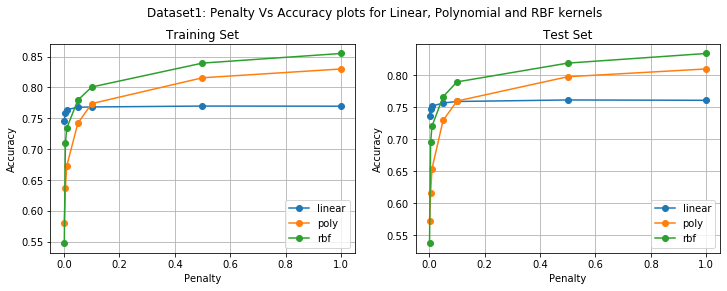

In [10]:
fig_1, ax_1 = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax_1[0].plot(x_train_lin, y_train_lin, 'o-', label = 'linear')
ax_1[0].plot(x_train_poly, y_train_poly, 'o-', label = 'poly')
ax_1[0].plot(x_train_rbf, y_train_rbf, 'o-', label = 'rbf')
ax_1[0].set(xlabel='Penalty', ylabel='Accuracy', title = 'Training Set')
ax_1[0].grid()
ax_1[0].legend(loc="lower right")


ax_1[1].plot(x_test_lin, y_test_lin, 'o-', label = 'linear')
ax_1[1].plot(x_test_poly, y_test_poly, 'o-', label = 'poly')
ax_1[1].plot(x_test_rbf, y_test_rbf, 'o-', label = 'rbf')
ax_1[1].set(xlabel='Penalty', ylabel='Accuracy', title = 'Test Set')
ax_1[1].grid()
ax_1[1].legend(loc="lower right")

fig_1.suptitle('Dataset1: Penalty Vs Accuracy plots for Linear, Polynomial and RBF kernels')
fig_1.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f48e5ccb70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f48f9c22e8>)

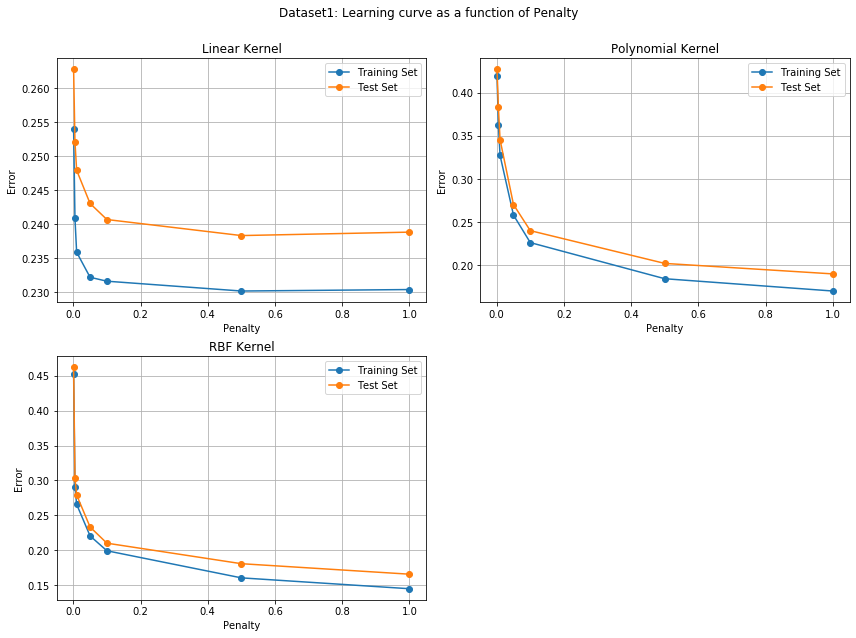

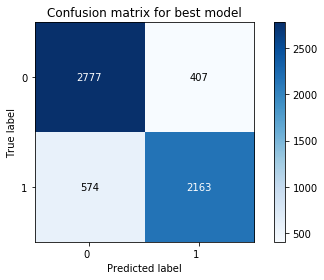

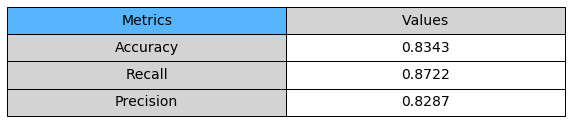

In [11]:
fig_2, ax_2 = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

ax_2[0,0].plot(x1_train_lin, y1_train_lin, 'o-', label = 'Training Set')
ax_2[0,0].plot(x1_test_lin, y1_test_lin, 'o-', label = 'Test Set')
ax_2[0,0].set(xlabel='Penalty', ylabel='Error', title='Linear Kernel')
ax_2[0,0].grid()
ax_2[0,0].legend(loc='upper right')

ax_2[0,1].plot(x1_train_poly, y1_train_poly, 'o-', label = 'Training Set')
ax_2[0,1].plot(x1_test_poly, y1_test_poly, 'o-', label = 'Test Set')
ax_2[0,1].set(xlabel='Penalty', ylabel='Error', title='Polynomial Kernel')
ax_2[0,1].grid()
ax_2[0,1].legend(loc='upper right')

ax_2[1,0].plot(x1_train_rbf, y1_train_rbf, 'o-', label = 'Training Set')
ax_2[1,0].plot(x1_test_rbf, y1_test_rbf, 'o-', label = 'Test Set')
ax_2[1,0].set(xlabel='Penalty', ylabel='Error', title='RBF Kernel')
ax_2[1,0].grid()
ax_2[1,0].legend(loc='upper right')

ax_2[1,1].set_axis_off()

fig_2.suptitle('Dataset1: Learning curve as a function of Penalty')
fig_2.tight_layout()
fig_2.subplots_adjust(top=0.90)

d1_svm_ex21_model = svm_model(svm_train_x, svm_train_y, 'rbf', 1, 3, 'scale', toler)
plot_confusion_matrix(svm_test_y, d1_svm_ex21_model.predict(svm_test_x), classes=set(svm_train_y))

**Dataset 2: Audit Data**

In [12]:
## Experimentation
# Expt 1 - Experimenting with Penalty parameter for 3 different kernels
kernel2 = ['linear','poly','rbf']
degree2 = [0,3,0]
C2 = [0.001, 0.01, 0.05, 0.1, 0.3, 0.7, 1]
toler = 0.001

svm2_kern_matrix_train = {}
svm2_kern_matrix_test = {}
svm2_err_matrix_train = {}
svm2_err_matrix_test = {}

for n in range(len(kernel2)):
    svm2_train_acc_matrix = {}
    svm2_test_acc_matrix = {}
    svm2_train_err_matrix = {}
    svm2_test_err_matrix = {}
    for c in C2:
        svm2_mod = svm_model(x2_train, y2_train, kernel2[n], c, degree2[n], 'scale', toler)
        svm2_test_acc_matrix[c] = svm2_mod.score(x2_test, y2_test)
        svm2_train_acc_matrix[c] = svm2_mod.score(x2_train, y2_train)
        svm2_test_err_matrix[c] = 1-svm2_mod.score(x2_test, y2_test)
        svm2_train_err_matrix[c] = 1-svm2_mod.score(x2_train, y2_train)
    svm2_kern_matrix_train[kernel2[n]] = svm2_train_acc_matrix
    svm2_kern_matrix_test[kernel2[n]] = svm2_test_acc_matrix
    svm2_err_matrix_train[kernel2[n]] = svm2_train_err_matrix
    svm2_err_matrix_test[kernel2[n]] = svm2_test_err_matrix

In [13]:
x_train_lin2, y_train_lin2 = zip(*sorted(svm2_kern_matrix_train['linear'].items()))
x_test_lin2, y_test_lin2 = zip(*sorted(svm2_kern_matrix_test['linear'].items()))

x_train_poly2, y_train_poly2 = zip(*sorted(svm2_kern_matrix_train['poly'].items()))
x_test_poly2, y_test_poly2 = zip(*sorted(svm2_kern_matrix_test['poly'].items()))

x_train_rbf2, y_train_rbf2 = zip(*sorted(svm2_kern_matrix_train['rbf'].items()))
x_test_rbf2, y_test_rbf2 = zip(*sorted(svm2_kern_matrix_test['rbf'].items()))

x2_train_lin2, y2_train_lin2 = zip(*sorted(svm2_err_matrix_train['linear'].items()))
x2_test_lin2, y2_test_lin2 = zip(*sorted(svm2_err_matrix_test['linear'].items()))

x2_train_poly2, y2_train_poly2 = zip(*sorted(svm2_err_matrix_train['poly'].items()))
x2_test_poly2, y2_test_poly2 = zip(*sorted(svm2_err_matrix_test['poly'].items()))

x2_train_rbf2, y2_train_rbf2 = zip(*sorted(svm2_err_matrix_train['rbf'].items()))
x2_test_rbf2, y2_test_rbf2 = zip(*sorted(svm2_err_matrix_test['rbf'].items()))

(<matplotlib.axes._subplots.AxesSubplot at 0x1f48f7c86d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f48f863e80>)

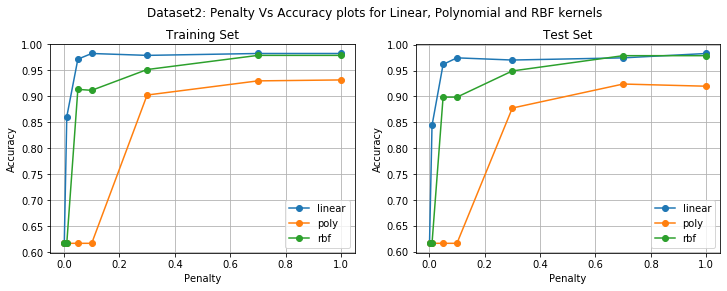

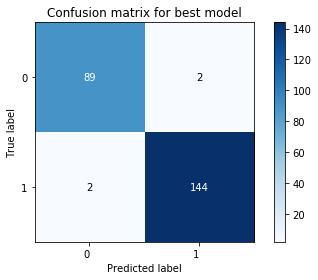

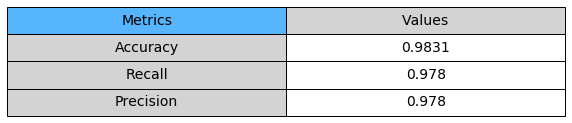

In [14]:
fig_21, ax_21 = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax_21[0].plot(x_train_lin2, y_train_lin2, 'o-', label = 'linear')
ax_21[0].plot(x_train_poly2, y_train_poly2, 'o-', label = 'poly')
ax_21[0].plot(x_train_rbf2, y_train_rbf2, 'o-', label = 'rbf')
ax_21[0].set(xlabel='Penalty', ylabel='Accuracy', title = 'Training Set')
ax_21[0].grid()
ax_21[0].legend(loc="lower right")


ax_21[1].plot(x_test_lin2, y_test_lin2, 'o-', label = 'linear')
ax_21[1].plot(x_test_poly2, y_test_poly2, 'o-', label = 'poly')
ax_21[1].plot(x_test_rbf2, y_test_rbf2, 'o-', label = 'rbf')
ax_21[1].set(xlabel='Penalty', ylabel='Accuracy', title = 'Test Set')
ax_21[1].grid()
ax_21[1].legend(loc="lower right")

fig_21.suptitle('Dataset2: Penalty Vs Accuracy plots for Linear, Polynomial and RBF kernels')
fig_21.subplots_adjust(top=0.85)

d2_svm_ex21_model = svm_model(x2_train, y2_train, 'linear', 1, 0, 'scale', toler)
plot_confusion_matrix(y2_test, d2_svm_ex21_model.predict(x2_test), classes=set(y2_train))

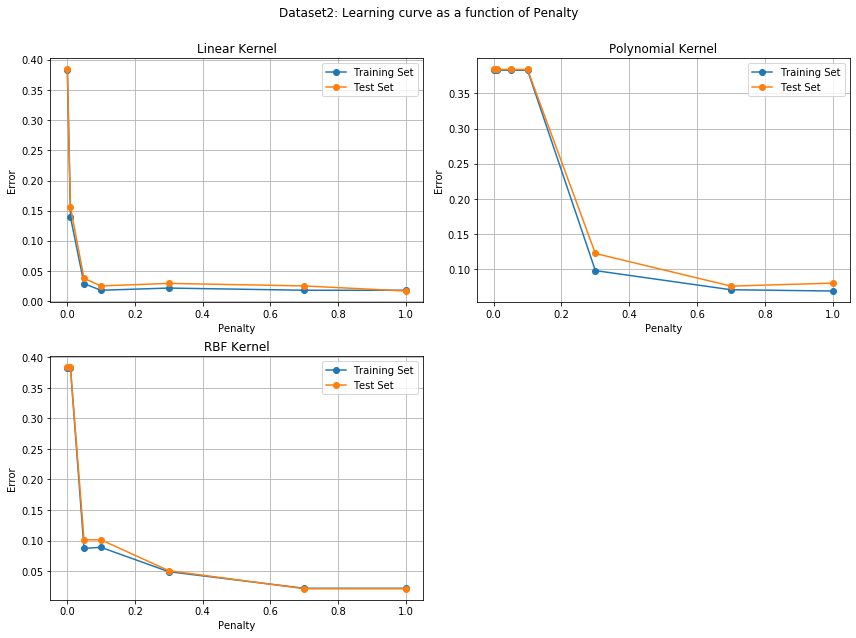

In [15]:
fig_22, ax_22 = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

ax_22[0,0].plot(x2_train_lin2, y2_train_lin2, 'o-', label = 'Training Set')
ax_22[0,0].plot(x2_test_lin2, y2_test_lin2, 'o-', label = 'Test Set')
ax_22[0,0].set(xlabel='Penalty', ylabel='Error', title='Linear Kernel')
ax_22[0,0].grid()
ax_22[0,0].legend(loc='best')

ax_22[0,1].plot(x2_train_poly2, y2_train_poly2, 'o-', label = 'Training Set')
ax_22[0,1].plot(x2_test_poly2, y2_test_poly2, 'o-', label = 'Test Set')
ax_22[0,1].set(xlabel='Penalty', ylabel='Error', title='Polynomial Kernel')
ax_22[0,1].grid()
ax_22[0,1].legend(loc='best')

ax_22[1,0].plot(x2_train_rbf2, y2_train_rbf2, 'o-', label = 'Training Set')
ax_22[1,0].plot(x2_test_rbf2, y2_test_rbf2, 'o-', label = 'Test Set')
ax_22[1,0].set(xlabel='Penalty', ylabel='Error', title='RBF Kernel')
ax_22[1,0].grid()
ax_22[1,0].legend(loc='best')

ax_22[1,1].set_axis_off()

fig_22.suptitle('Dataset2: Learning curve as a function of Penalty')
fig_22.tight_layout()
fig_22.subplots_adjust(top=0.90)

**EXPERIMENT 2.2 -** _Analysis of 'degree' parameter for Polynomial kernel for varying Penalty parameter values_

**Dataset 1 - Energy Data**

In [16]:
# Expt 2 - Experimenting with various degrees for polynomial function (with cost)
poly_degree = [2,3,4,5]
poly_C = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
poly_acc_matrix_train = {}
poly_acc_matrix_test = {}
poly_err_matrix_train = {}
poly_err_matrix_test = {}

for d in poly_degree:
    degree_train_acc = []
    degree_test_acc = []
    degree_train_err = []
    degree_test_err = []
    for c in poly_C:
        poly_svm_mod = svm_model(svm_train_x, svm_train_y, 'poly', c, d, 'scale', toler)
        degree_train_acc.append(poly_svm_mod.score(svm_train_x, svm_train_y))
        degree_test_acc.append(poly_svm_mod.score(svm_test_x, svm_test_y))
        degree_train_err.append(1-poly_svm_mod.score(svm_train_x, svm_train_y))
        degree_test_err.append(1-poly_svm_mod.score(svm_test_x, svm_test_y))
    poly_acc_matrix_train[d] = degree_train_acc
    poly_acc_matrix_test[d] = degree_test_acc
    poly_err_matrix_train[d] = degree_train_err
    poly_err_matrix_test[d] = degree_test_err

#print(poly_acc_matrix_train)
#print(poly_acc_matrix_test)

In [17]:
y2_train_poly = poly_acc_matrix_train[2]
y3_train_poly = poly_acc_matrix_train[3]
y4_train_poly = poly_acc_matrix_train[4]
y5_train_poly = poly_acc_matrix_train[5]

y2_test_poly = poly_acc_matrix_test[2]
y3_test_poly = poly_acc_matrix_test[3]
y4_test_poly = poly_acc_matrix_test[4]
y5_test_poly = poly_acc_matrix_test[5]

y12_train_poly = poly_err_matrix_train[2]
y13_train_poly = poly_err_matrix_train[3]
y14_train_poly = poly_err_matrix_train[4]
y15_train_poly = poly_err_matrix_train[5]

y12_test_poly = poly_err_matrix_test[2]
y13_test_poly = poly_err_matrix_test[3]
y14_test_poly = poly_err_matrix_test[4]
y15_test_poly = poly_err_matrix_test[5]

(<matplotlib.axes._subplots.AxesSubplot at 0x1f48ffcf208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f49036c860>)

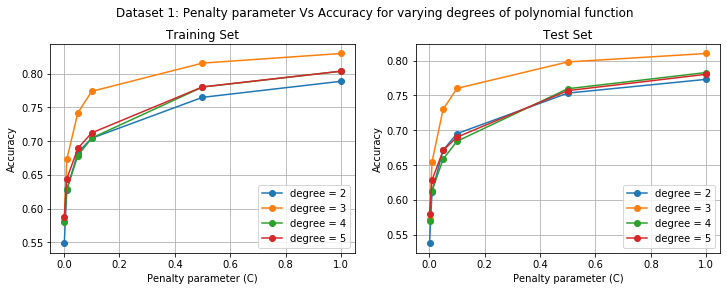

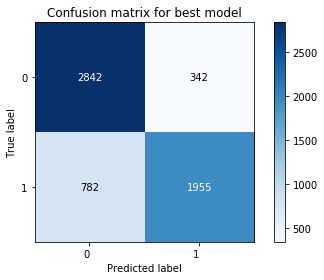

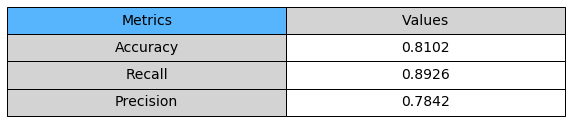

In [18]:
fig_poly, ax_poly = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax_poly[0].plot(poly_C, y2_train_poly, 'o-', label='degree = 2')
ax_poly[0].plot(poly_C, y3_train_poly, 'o-', label='degree = 3')
ax_poly[0].plot(poly_C, y4_train_poly, 'o-', label='degree = 4')
ax_poly[0].plot(poly_C, y5_train_poly, 'o-', label='degree = 5')
ax_poly[0].set(xlabel='Penalty parameter (C)', ylabel='Accuracy', title='Training Set')
ax_poly[0].grid()
ax_poly[0].legend(loc="lower right")

ax_poly[1].plot(poly_C, y2_test_poly, 'o-', label='degree = 2')
ax_poly[1].plot(poly_C, y3_test_poly, 'o-', label='degree = 3')
ax_poly[1].plot(poly_C, y4_test_poly, 'o-', label='degree = 4')
ax_poly[1].plot(poly_C, y5_test_poly, 'o-', label='degree = 5')
ax_poly[1].set(xlabel='Penalty parameter (C)', ylabel='Accuracy', title='Test Set')
ax_poly[1].grid()
ax_poly[1].legend(loc="lower right")

fig_poly.suptitle('Dataset 1: Penalty parameter Vs Accuracy for varying degrees of polynomial function')
fig_poly.subplots_adjust(top=0.85)

d1_svm_ex22_model = svm_model(svm_train_x, svm_train_y, 'poly', 1, 3, 'scale', toler)
plot_confusion_matrix(svm_test_y, d1_svm_ex22_model.predict(svm_test_x), classes=set(svm_train_y))

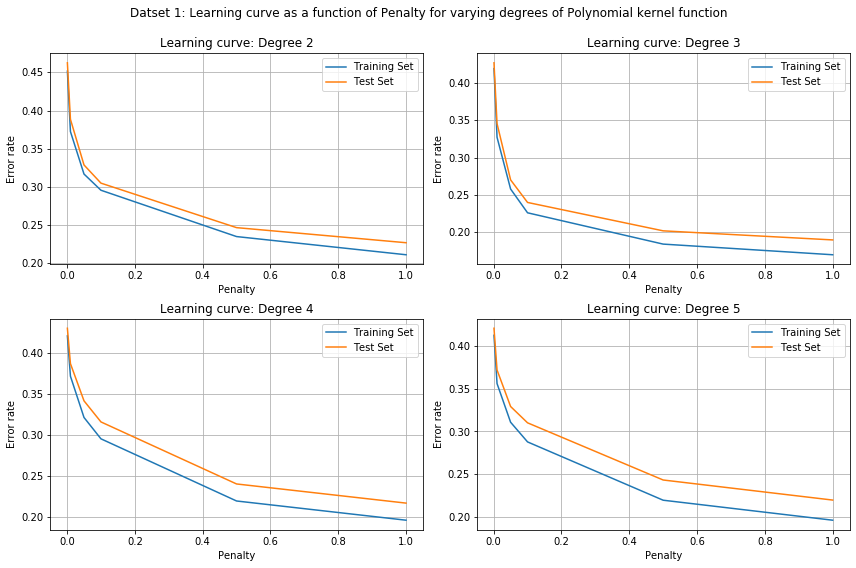

In [19]:
fig2_poly, ax2_poly = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

ax2_poly[0,0].plot(poly_C, y12_train_poly, label='Training Set')
ax2_poly[0,0].plot(poly_C, y12_test_poly, label='Test Set')
ax2_poly[0,0].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 2')
ax2_poly[0,0].grid()
ax2_poly[0,0].legend(loc='upper right')

ax2_poly[0,1].plot(poly_C, y13_train_poly, label='Training Set')
ax2_poly[0,1].plot(poly_C, y13_test_poly, label='Test Set')
ax2_poly[0,1].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 3')
ax2_poly[0,1].grid()
ax2_poly[0,1].legend(loc='upper right')

ax2_poly[1,0].plot(poly_C, y14_train_poly, label='Training Set')
ax2_poly[1,0].plot(poly_C, y14_test_poly, label='Test Set')
ax2_poly[1,0].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 4')
ax2_poly[1,0].grid()
ax2_poly[1,0].legend(loc='upper right')

ax2_poly[1,1].plot(poly_C, y15_train_poly, label='Training Set')
ax2_poly[1,1].plot(poly_C, y15_test_poly, label='Test Set')
ax2_poly[1,1].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 5')
ax2_poly[1,1].grid()
ax2_poly[1,1].legend(loc='upper right')

fig2_poly.tight_layout()
fig2_poly.suptitle('Datset 1: Learning curve as a function of Penalty for varying degrees of Polynomial kernel function')
fig2_poly.subplots_adjust(top=0.90)

**Dataset 2: Audit Data**

In [20]:
# Expt 2 - Experimenting with various degree2s for poly2nomial function (with cost)
poly2_degree2 = [2,3,4,5]
poly2_C = [0.001, 0.01, 0.05, 0.1, 0.3, 0.7, 1]
poly2_acc_matrix_train = {}
poly2_acc_matrix_test = {}
poly2_err_matrix_train = {}
poly2_err_matrix_test = {}

for d in poly2_degree2:
    degree2_train_acc = []
    degree2_test_acc = []
    degree2_train_err = []
    degree2_test_err = []
    for c in poly2_C:
        poly2_svm_mod = svm_model(x2_train, y2_train, 'poly', c, d, 'scale', toler)
        degree2_train_acc.append(poly2_svm_mod.score(x2_train, y2_train))
        degree2_test_acc.append(poly2_svm_mod.score(x2_test, y2_test))
        degree2_train_err.append(1-poly2_svm_mod.score(x2_train, y2_train))
        degree2_test_err.append(1-poly2_svm_mod.score(x2_test, y2_test))
    poly2_acc_matrix_train[d] = degree2_train_acc
    poly2_acc_matrix_test[d] = degree2_test_acc
    poly2_err_matrix_train[d] = degree2_train_err
    poly2_err_matrix_test[d] = degree2_test_err

#print(poly2_acc_matrix_train)
#print(poly2_acc_matrix_test)

In [21]:
y22_train_poly2 = poly2_acc_matrix_train[2]
y23_train_poly2 = poly2_acc_matrix_train[3]
y24_train_poly2 = poly2_acc_matrix_train[4]
y25_train_poly2 = poly2_acc_matrix_train[5]

y22_test_poly2 = poly2_acc_matrix_test[2]
y23_test_poly2 = poly2_acc_matrix_test[3]
y24_test_poly2 = poly2_acc_matrix_test[4]
y25_test_poly2 = poly2_acc_matrix_test[5]

y122_train_poly2 = poly2_err_matrix_train[2]
y123_train_poly2 = poly2_err_matrix_train[3]
y124_train_poly2 = poly2_err_matrix_train[4]
y125_train_poly2 = poly2_err_matrix_train[5]

y122_test_poly2 = poly2_err_matrix_test[2]
y123_test_poly2 = poly2_err_matrix_test[3]
y124_test_poly2 = poly2_err_matrix_test[4]
y125_test_poly2 = poly2_err_matrix_test[5]

(<matplotlib.axes._subplots.AxesSubplot at 0x1f491797a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f4918325c0>)

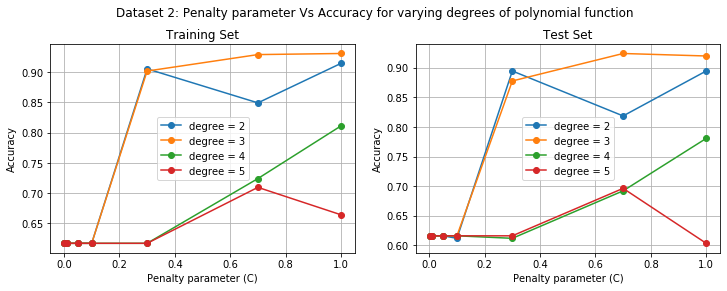

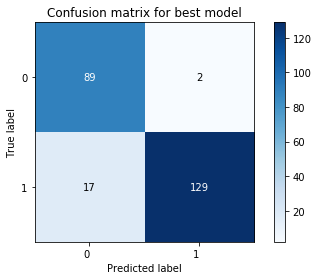

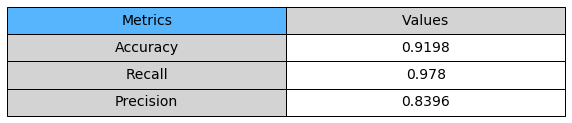

In [22]:
fig_poly2, ax_poly2 = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax_poly2[0].plot(poly2_C, y22_train_poly2, 'o-', label='degree = 2')
ax_poly2[0].plot(poly2_C, y23_train_poly2, 'o-', label='degree = 3')
ax_poly2[0].plot(poly2_C, y24_train_poly2, 'o-', label='degree = 4')
ax_poly2[0].plot(poly2_C, y25_train_poly2, 'o-', label='degree = 5')
ax_poly2[0].set(xlabel='Penalty parameter (C)', ylabel='Accuracy', title='Training Set')
ax_poly2[0].grid()
ax_poly2[0].legend(loc="best")

ax_poly2[1].plot(poly2_C, y22_test_poly2, 'o-', label='degree = 2')
ax_poly2[1].plot(poly2_C, y23_test_poly2, 'o-', label='degree = 3')
ax_poly2[1].plot(poly2_C, y24_test_poly2, 'o-', label='degree = 4')
ax_poly2[1].plot(poly2_C, y25_test_poly2, 'o-', label='degree = 5')
ax_poly2[1].set(xlabel='Penalty parameter (C)', ylabel='Accuracy', title='Test Set')
ax_poly2[1].grid()
ax_poly2[1].legend(loc="best")

fig_poly2.suptitle('Dataset 2: Penalty parameter Vs Accuracy for varying degrees of polynomial function')
fig_poly2.subplots_adjust(top=0.85)

d2_svm_ex22_model = svm_model(x2_train, y2_train, 'poly', 1, 3, 'scale', toler)
plot_confusion_matrix(y2_test, d2_svm_ex22_model.predict(x2_test), classes=set(y2_train))

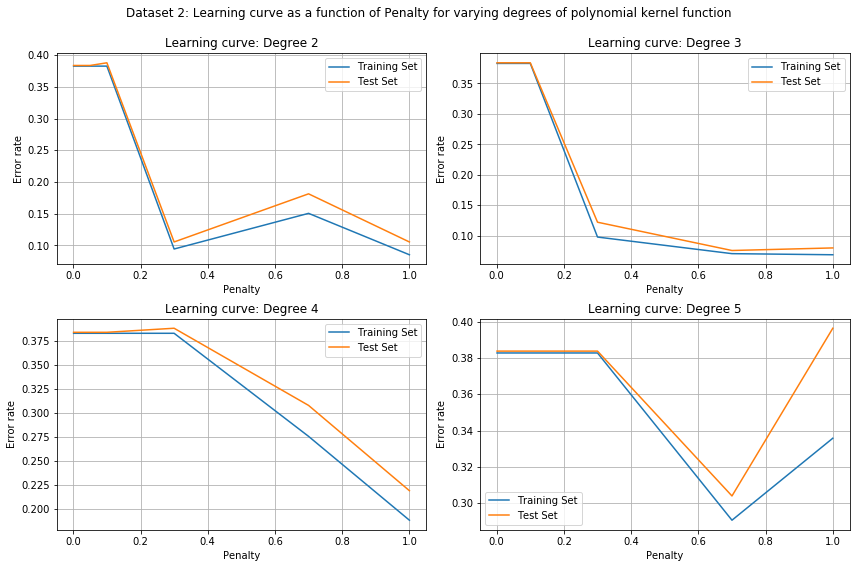

In [23]:
fig2_poly2, ax2_poly2 = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

ax2_poly2[0,0].plot(poly2_C, y122_train_poly2, label='Training Set')
ax2_poly2[0,0].plot(poly2_C, y122_test_poly2, label='Test Set')
ax2_poly2[0,0].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 2')
ax2_poly2[0,0].grid()
ax2_poly2[0,0].legend(loc='best')

ax2_poly2[0,1].plot(poly2_C, y123_train_poly2, label='Training Set')
ax2_poly2[0,1].plot(poly2_C, y123_test_poly2, label='Test Set')
ax2_poly2[0,1].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 3')
ax2_poly2[0,1].grid()
ax2_poly2[0,1].legend(loc='best')

ax2_poly2[1,0].plot(poly2_C, y124_train_poly2, label='Training Set')
ax2_poly2[1,0].plot(poly2_C, y124_test_poly2, label='Test Set')
ax2_poly2[1,0].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 4')
ax2_poly2[1,0].grid()
ax2_poly2[1,0].legend(loc='best')

ax2_poly2[1,1].plot(poly2_C, y125_train_poly2, label='Training Set')
ax2_poly2[1,1].plot(poly2_C, y125_test_poly2, label='Test Set')
ax2_poly2[1,1].set(xlabel='Penalty', ylabel='Error rate', title='Learning curve: Degree 5')
ax2_poly2[1,1].grid()
ax2_poly2[1,1].legend(loc='best')

fig2_poly2.tight_layout()
fig2_poly2.suptitle('Dataset 2: Learning curve as a function of Penalty for varying degrees of polynomial kernel function')
fig2_poly2.subplots_adjust(top=0.90)

**EXPERIMENT 2.3 -** _Analysis of 'gamma' parameter (extent of influence of kernel function) for Polynomial, Radial Basis kernel functions_

**Dataset 1 - Energy Data**

In [24]:
# Expt 3 - Experimenting with various gamma values (extent of influence) for Poly and RBF kernel
ex3_kern = ['poly','rbf']
ex3_gamma = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
ex3_acc_matrix_train = {}
ex3_acc_matrix_test = {}
ex3_err_matrix_train = {}
ex3_err_matrix_test = {}


for n in range(len(ex3_kern)):
    gamma_acc_matrix_train = []
    gamma_acc_matrix_test = []
    gamma_err_matrix_train = []
    gamma_err_matrix_test = []
    for g in ex3_gamma:
        rbf_svm_mod = svm_model(svm_train_x, svm_train_y, ex3_kern[n], 1, 3, g, toler)
        gamma_acc_matrix_train.append(rbf_svm_mod.score(svm_train_x, svm_train_y))
        gamma_acc_matrix_test.append(rbf_svm_mod.score(svm_test_x, svm_test_y))
        gamma_err_matrix_train.append(1-rbf_svm_mod.score(svm_train_x, svm_train_y))
        gamma_err_matrix_test.append(1-rbf_svm_mod.score(svm_test_x, svm_test_y))
    ex3_acc_matrix_train[ex3_kern[n]] = gamma_acc_matrix_train
    ex3_acc_matrix_test[ex3_kern[n]] = gamma_acc_matrix_test
    ex3_err_matrix_train[ex3_kern[n]] = gamma_err_matrix_train
    ex3_err_matrix_test[ex3_kern[n]] = gamma_err_matrix_test

In [25]:
y1_train_ex3 = ex3_acc_matrix_train[ex3_kern[0]]
y2_train_ex3 = ex3_acc_matrix_train[ex3_kern[1]]

y1_test_ex3 = ex3_acc_matrix_test[ex3_kern[0]]
y2_test_ex3 = ex3_acc_matrix_test[ex3_kern[1]]

y11_train_ex3 = ex3_err_matrix_train[ex3_kern[0]]
y12_train_ex3 = ex3_err_matrix_train[ex3_kern[1]]

y11_test_ex3 = ex3_err_matrix_test[ex3_kern[0]]
y12_test_ex3 = ex3_err_matrix_test[ex3_kern[1]]

(<matplotlib.axes._subplots.AxesSubplot at 0x1f491e4eb70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f4921e0358>)

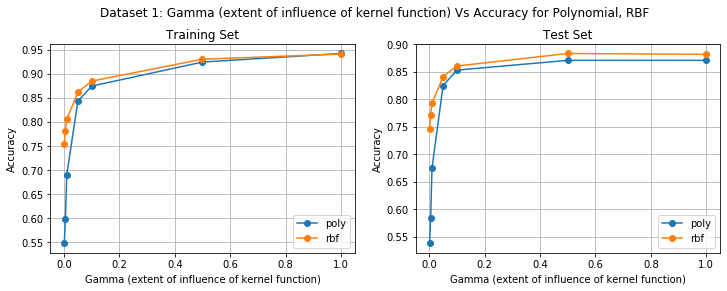

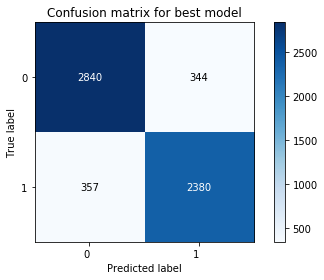

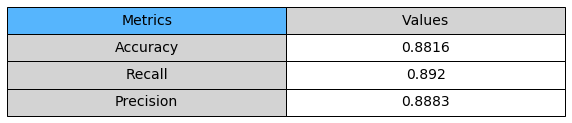

In [26]:
fig_rbf, ax_rbf = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_rbf[0].plot(ex3_gamma, y1_train_ex3, 'o-', label='poly')
ax_rbf[0].plot(ex3_gamma, y2_train_ex3, 'o-', label='rbf')
ax_rbf[0].grid()
ax_rbf[0].set(xlabel='Gamma (extent of influence of kernel function)', ylabel='Accuracy', title='Training Set')
ax_rbf[0].legend(loc='lower right')

ax_rbf[1].plot(ex3_gamma, y1_test_ex3, 'o-', label='poly')
ax_rbf[1].plot(ex3_gamma, y2_test_ex3, 'o-', label='rbf')
ax_rbf[1].set(xlabel='Gamma (extent of influence of kernel function)', ylabel='Accuracy', title='Test Set')
ax_rbf[1].grid()
ax_rbf[1].legend(loc='lower right')

fig_rbf.suptitle('Dataset 1: Gamma (extent of influence of kernel function) Vs Accuracy for Polynomial, RBF')
fig_rbf.subplots_adjust(top=0.85)

d1_svm_ex23_model = svm_model(svm_train_x, svm_train_y, 'rbf', 1, 3, 1, toler)
plot_confusion_matrix(svm_test_y, d1_svm_ex23_model.predict(svm_test_x), classes=set(svm_train_y))

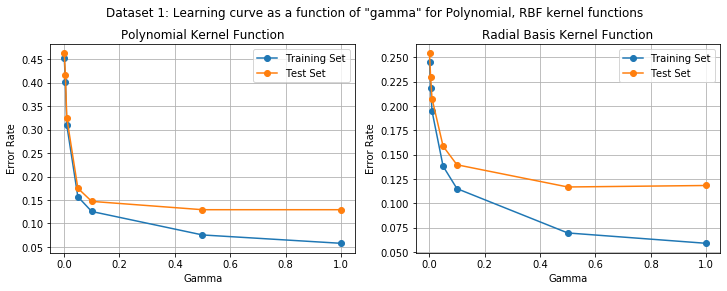

In [27]:
fig2_ex3, ax2_ex3 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax2_ex3[0].plot(ex3_gamma, y11_train_ex3, 'o-', label='Training Set')
ax2_ex3[0].plot(ex3_gamma, y11_test_ex3, 'o-', label='Test Set')
ax2_ex3[0].set(xlabel='Gamma', ylabel='Error Rate', title='Polynomial Kernel Function')
ax2_ex3[0].grid()
ax2_ex3[0].legend(loc='upper right')

ax2_ex3[1].plot(ex3_gamma, y12_train_ex3, 'o-', label='Training Set')
ax2_ex3[1].plot(ex3_gamma, y12_test_ex3, 'o-', label='Test Set')
ax2_ex3[1].set(xlabel='Gamma', ylabel='Error Rate', title='Radial Basis Kernel Function')
ax2_ex3[1].grid()
ax2_ex3[1].legend(loc='upper right')

fig2_ex3.suptitle('Dataset 1: Learning curve as a function of "gamma" for Polynomial, RBF kernel functions')
fig2_ex3.subplots_adjust(top=0.85)

**Dataset 2 - Audit data**

In [28]:
# Expt 3 - Experimenting with various gamma values (extent of influence) for Poly and RBF kernel
ex3_2_kern = ['poly','rbf']
ex3_2_gamma = [0.0001, 0.001, 0.01,0.1, 1, 5, 10]
ex3_2_acc_matrix_train = {}
ex3_2_acc_matrix_test = {}
ex3_2_err_matrix_train = {}
ex3_2_err_matrix_test = {}


for n in range(len(ex3_2_kern)):
    gamma_2_acc_matrix_train = []
    gamma_2_acc_matrix_test = []
    gamma_2_err_matrix_train = []
    gamma_2_err_matrix_test = []
    for g in ex3_2_gamma:
        rbf_svm_mod2 = svm_model(x2_train, y2_train, ex3_2_kern[n], 1, 3, g, toler)
        gamma_2_acc_matrix_train.append(rbf_svm_mod2.score(x2_train, y2_train))
        gamma_2_acc_matrix_test.append(rbf_svm_mod2.score(x2_test, y2_test))
        gamma_2_err_matrix_train.append(1-rbf_svm_mod2.score(x2_train, y2_train))
        gamma_2_err_matrix_test.append(1-rbf_svm_mod2.score(x2_test, y2_test))
    ex3_2_acc_matrix_train[ex3_2_kern[n]] = gamma_2_acc_matrix_train
    ex3_2_acc_matrix_test[ex3_2_kern[n]] = gamma_2_acc_matrix_test
    ex3_2_err_matrix_train[ex3_2_kern[n]] = gamma_2_err_matrix_train
    ex3_2_err_matrix_test[ex3_2_kern[n]] = gamma_2_err_matrix_test

In [29]:
y1_train_ex3_2 = ex3_2_acc_matrix_train[ex3_2_kern[0]]
y2_train_ex3_2 = ex3_2_acc_matrix_train[ex3_2_kern[1]]

y1_test_ex3_2 = ex3_2_acc_matrix_test[ex3_2_kern[0]]
y2_test_ex3_2 = ex3_2_acc_matrix_test[ex3_2_kern[1]]

y11_train_ex3_2 = ex3_2_err_matrix_train[ex3_2_kern[0]]
y12_train_ex3_2 = ex3_2_err_matrix_train[ex3_2_kern[1]]

y11_test_ex3_2 = ex3_2_err_matrix_test[ex3_2_kern[0]]
y12_test_ex3_2 = ex3_2_err_matrix_test[ex3_2_kern[1]]

(<matplotlib.axes._subplots.AxesSubplot at 0x1f49341e2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f4934ade48>)

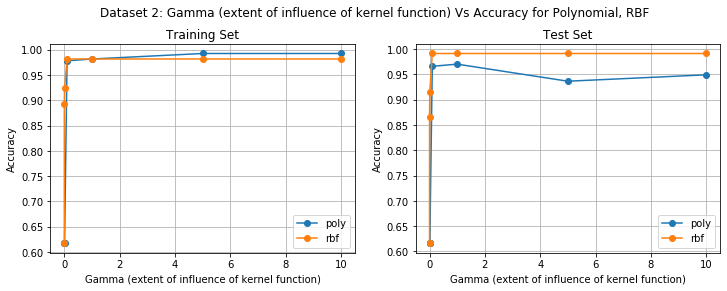

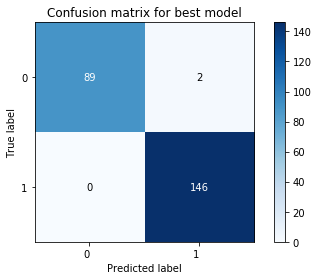

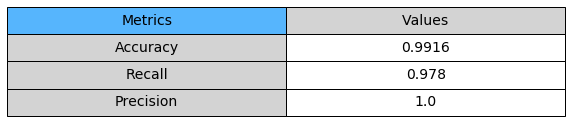

In [30]:
fig_rbf2, ax_rbf2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_rbf2[0].plot(ex3_2_gamma, y1_train_ex3_2, 'o-', label='poly')
ax_rbf2[0].plot(ex3_2_gamma, y2_train_ex3_2, 'o-', label='rbf')
ax_rbf2[0].grid()
ax_rbf2[0].set(xlabel='Gamma (extent of influence of kernel function)', ylabel='Accuracy', title='Training Set')
ax_rbf2[0].legend(loc='lower right')

ax_rbf2[1].plot(ex3_2_gamma, y1_test_ex3_2, 'o-', label='poly')
ax_rbf2[1].plot(ex3_2_gamma, y2_test_ex3_2, 'o-', label='rbf')
ax_rbf2[1].set(xlabel='Gamma (extent of influence of kernel function)', ylabel='Accuracy', title='Test Set')
ax_rbf2[1].grid()
ax_rbf2[1].legend(loc='lower right')

fig_rbf2.suptitle('Dataset 2: Gamma (extent of influence of kernel function) Vs Accuracy for Polynomial, RBF')
fig_rbf2.subplots_adjust(top=0.85)

d2_svm_ex23_model = svm_model(x2_train, y2_train, 'rbf', 1, 3, 1, toler)
plot_confusion_matrix(y2_test, d2_svm_ex23_model.predict(x2_test), classes=set(y2_train))

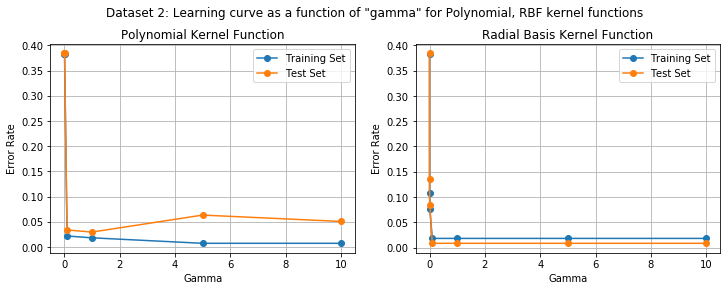

In [31]:
fig2_rbf2, ax2_rbf2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax2_rbf2[0].plot(ex3_2_gamma, y11_train_ex3_2, 'o-', label='Training Set')
ax2_rbf2[0].plot(ex3_2_gamma, y11_test_ex3_2, 'o-', label='Test Set')
ax2_rbf2[0].set(xlabel='Gamma', ylabel='Error Rate', title='Polynomial Kernel Function')
ax2_rbf2[0].grid()
ax2_rbf2[0].legend(loc='best')

ax2_rbf2[1].plot(ex3_2_gamma, y12_train_ex3_2, 'o-', label='Training Set')
ax2_rbf2[1].plot(ex3_2_gamma, y12_test_ex3_2, 'o-', label='Test Set')
ax2_rbf2[1].set(xlabel='Gamma', ylabel='Error Rate', title='Radial Basis Kernel Function')
ax2_rbf2[1].grid()
ax2_rbf2[1].legend(loc='best')

fig2_rbf2.suptitle('Dataset 2: Learning curve as a function of "gamma" for Polynomial, RBF kernel functions')
fig2_rbf2.subplots_adjust(top=0.85)

**EXPERIMENT 2.4 -** _Learning curves as a function of Training size for various kernels_

**Dataset 1 - Energy Data**

In [32]:
import time
ex4_size = [0.6, 0.7, 0.8, 0.9, 1]
ex4_kern = ['linear', 'poly', 'rbf']
ex4_err_matrix_train = {}
ex4_err_matrix_test = {}
ex5_clock_matrix = {}

for k in ex4_kern:
    ex4_err_train = []
    ex4_err_test = []
    ex5_clock_time = []
    for s in ex4_size:
        num = round(s*svm_train_x.shape[0])
        start = time.time()
        ex4_model = svm_model(svm_train_x.loc[:num], svm_train_y.loc[:num], k, 1, 3, 'scale', toler)
        stop = time.time()
        ex4_err_train.append(1-ex4_model.score(svm_train_x, svm_train_y))
        ex4_err_test.append(1-ex4_model.score(svm_test_x, svm_test_y))
        ex5_clock_time.append(stop-start)
    ex4_err_matrix_train[k] = ex4_err_train
    ex4_err_matrix_test[k] = ex4_err_test
    ex5_clock_matrix[k] = ex5_clock_time

In [33]:
y1_train_ex4 = ex4_err_matrix_train['linear']
y1_test_ex4 = ex4_err_matrix_test['linear']

y2_train_ex4 = ex4_err_matrix_train['poly']
y2_test_ex4 = ex4_err_matrix_test['poly']

y3_train_ex4 = ex4_err_matrix_train['rbf']
y3_test_ex4 = ex4_err_matrix_test['rbf']

(<matplotlib.axes._subplots.AxesSubplot at 0x1f4948cad68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f49495efd0>)

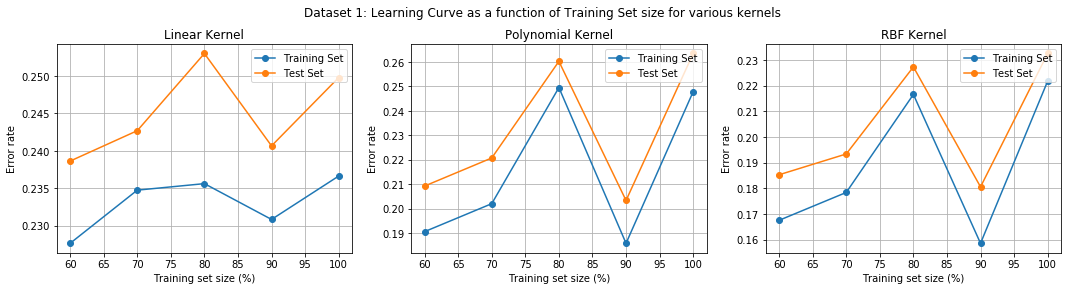

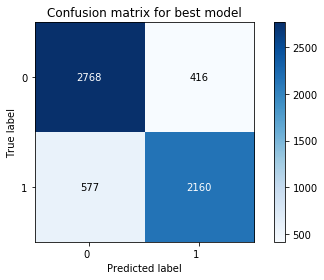

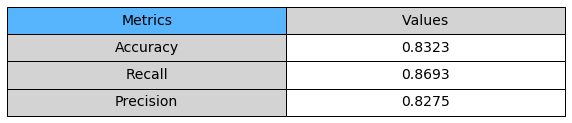

In [34]:
fig_ex4, ax_ex4 = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

x_ex4 = [s*100 for s in ex4_size]

ax_ex4[0].plot(x_ex4, y1_train_ex4, 'o-', label='Training Set')
ax_ex4[0].plot(x_ex4, y1_test_ex4, 'o-', label='Test Set')
ax_ex4[0].set(xlabel='Training set size (%)', ylabel='Error rate', title='Linear Kernel')
ax_ex4[0].grid()
ax_ex4[0].legend(loc='upper right')

ax_ex4[1].plot(x_ex4, y2_train_ex4,'o-', label='Training Set')
ax_ex4[1].plot(x_ex4, y2_test_ex4, 'o-', label='Test Set')
ax_ex4[1].set(xlabel='Training set size (%)', ylabel='Error rate', title='Polynomial Kernel')
ax_ex4[1].grid()
ax_ex4[1].legend(loc='upper right')

ax_ex4[2].plot(x_ex4, y3_train_ex4, 'o-', label='Training Set')
ax_ex4[2].plot(x_ex4, y3_test_ex4, 'o-', label='Test Set')
ax_ex4[2].set(xlabel='Training set size (%)', ylabel='Error rate', title='RBF Kernel')
ax_ex4[2].grid()
ax_ex4[2].legend(loc='upper right')

fig_ex4.suptitle('Dataset 1: Learning Curve as a function of Training Set size for various kernels')
fig_ex4.subplots_adjust(top=0.85)

d1_num24 = round(0.9*svm_train_x.shape[0])
d1_svm_ex24_model = svm_model(svm_train_x[:d1_num24], svm_train_y[:d1_num24], 'rbf', 1, 3, 'scale', toler)
plot_confusion_matrix(svm_test_y, d1_svm_ex24_model.predict(svm_test_x), classes=set(svm_train_y))

**Dataset 2 - Audit Data**

In [35]:
import time
ex4_2_size = [0.6, 0.7, 0.8, 0.9, 1]
ex4_2_kern = ['linear', 'poly', 'rbf']
ex4_2_err_matrix_train = {}
ex4_2_err_matrix_test = {}
ex5_2_clock_matrix = {}

for k in ex4_2_kern:
    ex4_2_err_train = []
    ex4_2_err_test = []
    ex5_2_clock_time = []
    for s in ex4_2_size:
        num = round(s*x2_train.shape[0])+1
        start2 = time.perf_counter()
        ex4_2_model = svm_model(x2_train.loc[:num], y2_train.loc[:num], k, 1, 3, 'scale', toler)
        stop2 = time.perf_counter()
        ex4_2_err_train.append(1-ex4_2_model.score(x2_train, y2_train))
        ex4_2_err_test.append(1-ex4_2_model.score(x2_test, y2_test))
        ex5_2_clock_time.append(stop2-start2)
    ex4_2_err_matrix_train[k] = ex4_2_err_train
    ex4_2_err_matrix_test[k] = ex4_2_err_test
    ex5_2_clock_matrix[k] = ex5_2_clock_time

In [36]:
y1_train_ex4_2 = ex4_2_err_matrix_train['linear']
y1_test_ex4_2 = ex4_2_err_matrix_test['linear']

y2_train_ex4_2 = ex4_2_err_matrix_train['poly']
y2_test_ex4_2 = ex4_2_err_matrix_test['poly']

y3_train_ex4_2 = ex4_2_err_matrix_train['rbf']
y3_test_ex4_2 = ex4_2_err_matrix_test['rbf']

(<matplotlib.axes._subplots.AxesSubplot at 0x1f494a3ea58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f494ace240>)

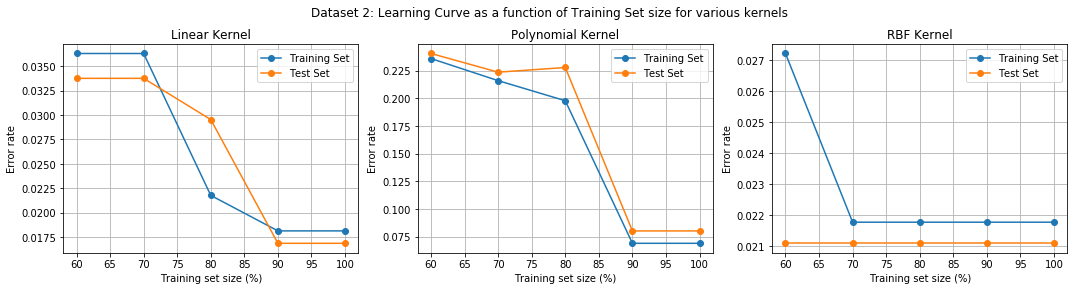

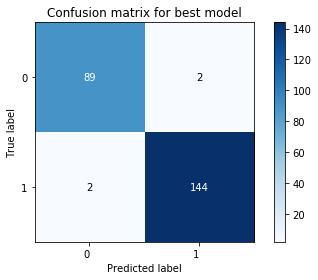

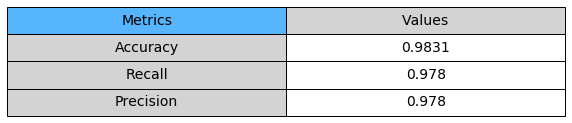

In [37]:
fig_ex4_2, ax_ex4_2 = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

x_ex4_2 = [s*100 for s in ex4_2_size]

ax_ex4_2[0].plot(x_ex4_2, y1_train_ex4_2, 'o-', label='Training Set')
ax_ex4_2[0].plot(x_ex4_2, y1_test_ex4_2, 'o-', label='Test Set')
ax_ex4_2[0].set(xlabel='Training set size (%)', ylabel='Error rate', title='Linear Kernel')
ax_ex4_2[0].grid()
ax_ex4_2[0].legend(loc='upper right')

ax_ex4_2[1].plot(x_ex4_2, y2_train_ex4_2,'o-', label='Training Set')
ax_ex4_2[1].plot(x_ex4_2, y2_test_ex4_2, 'o-', label='Test Set')
ax_ex4_2[1].set(xlabel='Training set size (%)', ylabel='Error rate', title='Polynomial Kernel')
ax_ex4_2[1].grid()
ax_ex4_2[1].legend(loc='upper right')

ax_ex4_2[2].plot(x_ex4_2, y3_train_ex4_2, 'o-', label='Training Set')
ax_ex4_2[2].plot(x_ex4_2, y3_test_ex4_2, 'o-', label='Test Set')
ax_ex4_2[2].set(xlabel='Training set size (%)', ylabel='Error rate', title='RBF Kernel')
ax_ex4_2[2].grid()
ax_ex4_2[2].legend(loc='upper right')

fig_ex4_2.suptitle('Dataset 2: Learning Curve as a function of Training Set size for various kernels')
fig_ex4_2.subplots_adjust(top=0.85)

d2_svm_ex24_model = svm_model(x2_train, y2_train, 'linear', 1, 3, 'scale', toler)
plot_confusion_matrix(y2_test, d2_svm_ex24_model.predict(x2_test), classes=set(y2_train))

**Decision Tree Experimentation**

**EXPERIMENT 3.1 -** _Learning curves as a function of depth of the tree_

In [42]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

def DT(x, y, maxdepth, threshold_impurity):
    if(maxdepth==0):
        dt_model = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease = threshold_impurity, random_state = random_num)
    else:
        dt_model = DecisionTreeClassifier(criterion='entropy', max_depth = maxdepth, min_impurity_decrease = threshold_impurity, random_state = random_num)
    dt_model.fit(x,y)
    return(dt_model)

**Dataset 1 - Energy Data**

In [43]:
# Train test split       
from sklearn.model_selection import train_test_split
d1_train, d1_test = train_test_split(dt_data, test_size = 0.3, random_state = 40)

d1_train_y = d1_train[target_col]
d1_train_x = d1_train.loc[:, d1_train.columns!=target_col]
d1_test_y = d1_test[target_col]
d1_test_x = d1_test.loc[:, d1_test.columns!=target_col]

dt_depth = range(1,30)
dt_depth_acc_train = []
dt_depth_acc_test = []
dt_depth_err_train = []
dt_depth_err_test = []

for d in dt_depth:
    dt_mod = DT(d1_train_x, d1_train_y, d, 0)
    dt_depth_acc_train.append(dt_mod.score(d1_train_x, d1_train_y))
    dt_depth_acc_test.append(dt_mod.score(d1_test_x, d1_test_y))
    dt_depth_err_train.append(1-dt_mod.score(d1_train_x, d1_train_y))
    dt_depth_err_test.append(1-dt_mod.score(d1_test_x, d1_test_y))

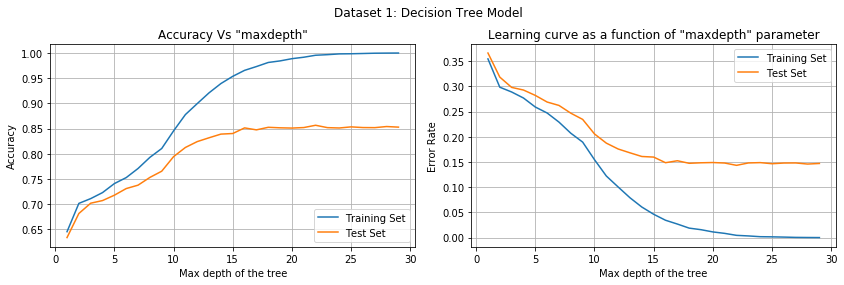

In [44]:
fig_dt1, ax_dt1 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

ax_dt1[0].plot(dt_depth, dt_depth_acc_train, label='Training Set')
ax_dt1[0].plot(dt_depth, dt_depth_acc_test, label = 'Test Set')
ax_dt1[0].set(xlabel='Max depth of the tree', ylabel='Accuracy', title='Accuracy Vs "maxdepth"')
ax_dt1[0].grid()
ax_dt1[0].legend(loc='lower right')

ax_dt1[1].plot(dt_depth, dt_depth_err_train, label='Training Set')
ax_dt1[1].plot(dt_depth, dt_depth_err_test, label = 'Test Set')
ax_dt1[1].set(xlabel='Max depth of the tree', ylabel='Error Rate', title='Learning curve as a function of "maxdepth" parameter')
ax_dt1[1].grid()
ax_dt1[1].legend(loc='upper right')

fig_dt1.tight_layout()
fig_dt1.suptitle('Dataset 1: Decision Tree Model')
fig_dt1.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f495eece10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f495f5cda0>)

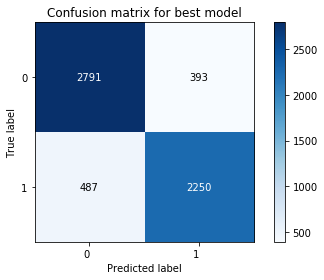

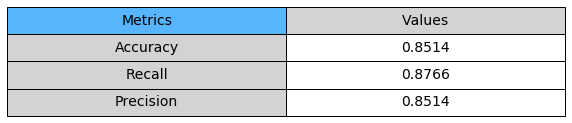

In [45]:
import graphviz
from sklearn import tree
d1_model = DT(d1_train_x, d1_train_y, 16, 0)
cols = list(d1_train_x.columns)
dot_data = tree.export_graphviz(d1_model,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset1_DT_BestModel_maxdepth",view=True)

plot_confusion_matrix(d1_test_y, d1_model.predict(d1_test_x), classes=set(d1_train_y))

**Dataset 2 - Audit Data**

In [46]:
# Train Test split
from sklearn.model_selection import train_test_split,cross_val_score
d2_train_x, d2_test_x, d2_train_y, d2_test_y = train_test_split(X2, Y2, test_size = 0.3,stratify=Y2, random_state = 4)

In [47]:
d2_depth_acc_train = []
d2_depth_acc_test = []
d2_depth_err_train = []
d2_depth_err_test = []
d2_depth = range(1,11)

for d in d2_depth:
    d2_mod = DT(d2_train_x, d2_train_y, d, 0)
    d2_depth_acc_train.append(d2_mod.score(d2_train_x, d2_train_y))
    d2_depth_acc_test.append(d2_mod.score(d2_test_x, d2_test_y))
    d2_depth_err_train.append(1-d2_mod.score(d2_train_x, d2_train_y))
    d2_depth_err_test.append(1-d2_mod.score(d2_test_x, d2_test_y))

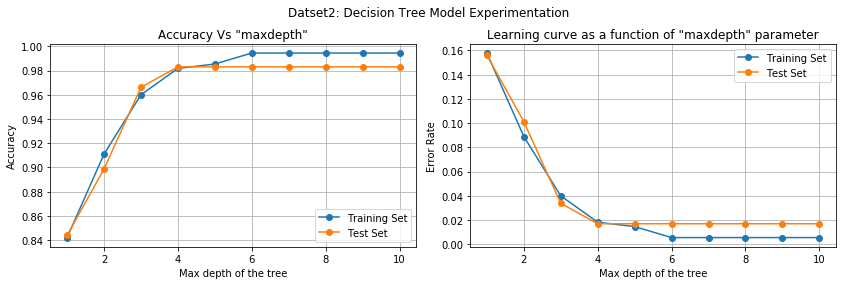

In [48]:
fig_dt2, ax_dt2 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

ax_dt2[0].plot(d2_depth, d2_depth_acc_train, 'o-', label='Training Set')
ax_dt2[0].plot(d2_depth, d2_depth_acc_test, 'o-', label = 'Test Set')
ax_dt2[0].set(xlabel='Max depth of the tree', ylabel='Accuracy', title='Accuracy Vs "maxdepth"')
ax_dt2[0].grid()
ax_dt2[0].legend(loc='lower right')

ax_dt2[1].plot(d2_depth, d2_depth_err_train, 'o-', label='Training Set')
ax_dt2[1].plot(d2_depth, d2_depth_err_test, 'o-', label = 'Test Set')
ax_dt2[1].set(xlabel='Max depth of the tree', ylabel='Error Rate', title='Learning curve as a function of "maxdepth" parameter')
ax_dt2[1].grid()
ax_dt2[1].legend(loc='upper right')

fig_dt2.tight_layout()
fig_dt2.suptitle('Datset2: Decision Tree Model Experimentation')
fig_dt2.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f4960c2e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f49614bc88>)

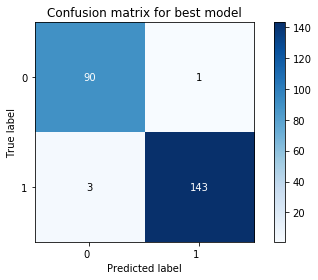

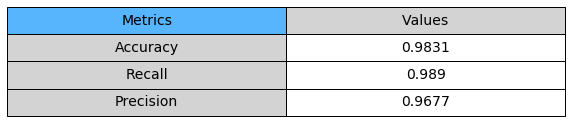

In [49]:
import graphviz
from sklearn import tree
d2_model = DT(d2_train_x, d2_train_y, 4, 0)
cols = list(d2_train_x.columns)
dot_data = tree.export_graphviz(d2_model,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset2_DT_BestModel_maxdepth",view=True)

plot_confusion_matrix(d2_test_y, d2_model.predict(d2_test_x), classes=set(d2_train_y))

**EXPERIMENT 3.2 -** _Experimenting with pruning_

**Dataset 1: Energy data**

In [50]:
# Pruning function based on number of samples as control parameter
from sklearn.tree._tree import TREE_LEAF

def pruning_dt(dtree, index, threshold):
    if dtree.tree_.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        dtree.tree_.children_left[index] = TREE_LEAF
        dtree.tree_.children_right[index] = TREE_LEAF
    # traversing through child nodes as well
    if dtree.tree_.children_left[index] != TREE_LEAF:
        pruning_dt(dtree, dtree.tree_.children_left[index], threshold)
        pruning_dt(dtree, dtree.tree_.children_right[index], threshold)
    return(dtree)

In [51]:
prunes = range(1,10)
dd_depth_acc_train_orig = []
dd_depth_acc_test_orig = []
dd_depth_acc_train = []
dd_depth_acc_test = []
dd_depth_err_train_orig = []
dd_depth_err_test_orig = []
dd_depth_err_train = []
dd_depth_err_test = []

for p in prunes:
    dd_mod = DT(d1_train_x, d1_train_y, 27, 0)
    dd_depth_acc_train_orig.append(dd_mod.score(d1_train_x, d1_train_y))
    dd_depth_err_train_orig.append(1-dd_mod.score(d1_train_x, d1_train_y))
    dd_depth_acc_test_orig.append(dd_mod.score(d1_test_x, d1_test_y))
    dd_depth_err_test_orig.append(1-dd_mod.score(d1_test_x, d1_test_y))
    
    dd_mod2 = pruning_dt(dd_mod, 0, p)
    dd_depth_acc_train.append(dd_mod2.score(d1_train_x, d1_train_y))
    dd_depth_acc_test.append(dd_mod2.score(d1_test_x, d1_test_y))
    dd_depth_err_train.append(1-dd_mod2.score(d1_train_x, d1_train_y))
    dd_depth_err_test.append(1-dd_mod2.score(d1_test_x, d1_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x1f496298f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f4963198d0>)

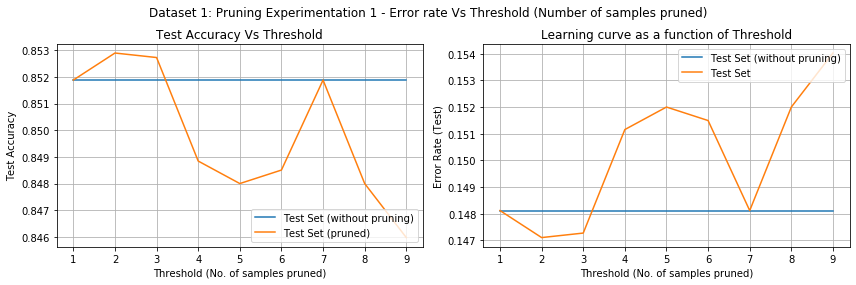

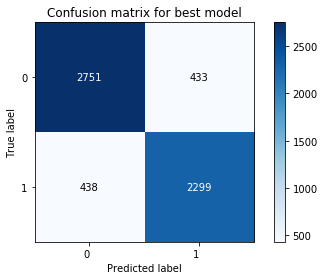

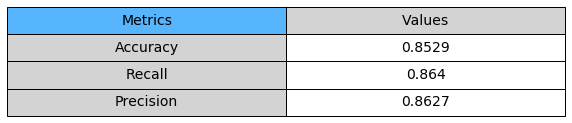

In [52]:
fig_dd, ax_dd = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

#ax_dd[0].plot(prunes, dd_depth_acc_train_orig, label='Training Set (without pruning)')
ax_dd[0].plot(prunes, dd_depth_acc_test_orig, label='Test Set (without pruning)')
#ax_dd[0].plot(prunes, dd_depth_acc_train, label='Training Set (pruned)')
ax_dd[0].plot(prunes, dd_depth_acc_test, label = 'Test Set (pruned)')
ax_dd[0].set(xlabel='Threshold (No. of samples pruned)', ylabel='Test Accuracy', title='Test Accuracy Vs Threshold')
ax_dd[0].grid()
ax_dd[0].legend(loc='lower right')

#ax_dd[1].plot(prunes, dd_depth_err_train_orig, label='Training Set (without pruning)')
ax_dd[1].plot(prunes, dd_depth_err_test_orig, label='Test Set (without pruning)')
#ax_dd[1].plot(prunes, dd_depth_err_train, label='Training Set (pruned)')
ax_dd[1].plot(prunes, dd_depth_err_test, label = 'Test Set')
ax_dd[1].set(xlabel='Threshold (No. of samples pruned)', ylabel='Error Rate (Test)', title='Learning curve as a function of Threshold')
ax_dd[1].grid()
ax_dd[1].legend(loc='upper right')

fig_dd.tight_layout()
fig_dd.suptitle('Dataset 1: Pruning Experimentation 1 - Error rate Vs Threshold (Number of samples pruned)')
fig_dd.subplots_adjust(top=0.85)

import graphviz
from sklearn import tree
d1_model_ex2 = DT(d1_train_x, d1_train_y, 27, 0)
d1_model_ex2 = pruning_dt(d1_model_ex2, 0, 2)
cols = list(d1_train_x.columns)
dot_data = tree.export_graphviz(d1_model_ex2,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset1_DT_BestModel_pruning",view=True)

plot_confusion_matrix(d1_test_y, d1_model_ex2.predict(d1_test_x), classes=set(d1_train_y))

In [53]:
d1_depth_acc_train_orig = []
d1_depth_acc_test_orig = []
d1_depth_acc_train = []
d1_depth_acc_test = []
d1_depth_err_train_orig = []
d1_depth_err_test_orig = []
d1_depth_err_train = []
d1_depth_err_test = []

for d in dt_depth:
    d1_mod = DT(d1_train_x, d1_train_y, d, 0)
    d1_depth_acc_train_orig.append(d1_mod.score(d1_train_x, d1_train_y))
    d1_depth_err_train_orig.append(1-d1_mod.score(d1_train_x, d1_train_y))
    d1_depth_acc_test_orig.append(d1_mod.score(d1_test_x, d1_test_y))
    d1_depth_err_test_orig.append(1-d1_mod.score(d1_test_x, d1_test_y))
    
    d1_mod2 = pruning_dt(d1_mod, 0, 5)
    d1_depth_acc_train.append(d1_mod2.score(d1_train_x, d1_train_y))
    d1_depth_acc_test.append(d1_mod2.score(d1_test_x, d1_test_y))
    d1_depth_err_train.append(1-d1_mod2.score(d1_train_x, d1_train_y))
    d1_depth_err_test.append(1-d1_mod2.score(d1_test_x, d1_test_y))

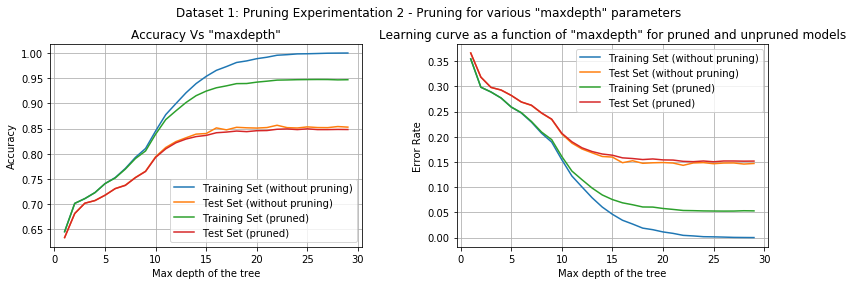

In [54]:
fig_d1, ax_d1 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

ax_d1[0].plot(dt_depth, d1_depth_acc_train_orig, label='Training Set (without pruning)')
ax_d1[0].plot(dt_depth, d1_depth_acc_test_orig, label='Test Set (without pruning)')
ax_d1[0].plot(dt_depth, d1_depth_acc_train, label='Training Set (pruned)')
ax_d1[0].plot(dt_depth, d1_depth_acc_test, label = 'Test Set (pruned)')
ax_d1[0].set(xlabel='Max depth of the tree', ylabel='Accuracy', title='Accuracy Vs "maxdepth"')
ax_d1[0].grid()
ax_d1[0].legend(loc='lower right')

ax_d1[1].plot(dt_depth, d1_depth_err_train_orig, label='Training Set (without pruning)')
ax_d1[1].plot(dt_depth, d1_depth_err_test_orig, label='Test Set (without pruning)')
ax_d1[1].plot(dt_depth, d1_depth_err_train, label='Training Set (pruned)')
ax_d1[1].plot(dt_depth, d1_depth_err_test, label = 'Test Set (pruned)')
ax_d1[1].set(xlabel='Max depth of the tree', ylabel='Error Rate', title='Learning curve as a function of "maxdepth" for pruned and unpruned models')
ax_d1[1].grid()
ax_d1[1].legend(loc='upper right')

fig_d1.tight_layout()
fig_d1.suptitle('Dataset 1: Pruning Experimentation 2 - Pruning for various "maxdepth" parameters')
fig_d1.subplots_adjust(top=0.85)

**Dataset 2: Audit Data**

In [55]:
prunes2 = [10,20,30,40,50,60]
dd2_depth_acc_train_orig = []
dd2_depth_acc_test_orig = []
dd2_depth_acc_train = []
dd2_depth_acc_test = []
dd2_depth_err_train_orig = []
dd2_depth_err_test_orig = []
dd2_depth_err_train = []
dd2_depth_err_test = []

for p in prunes2:
    dd2_mod = DT(d2_train_x, d2_train_y, 4, 0)
    dd2_depth_acc_train_orig.append(dd2_mod.score(d2_train_x, d2_train_y))
    dd2_depth_err_train_orig.append(1-dd2_mod.score(d2_train_x, d2_train_y))
    dd2_depth_acc_test_orig.append(dd2_mod.score(d2_test_x, d2_test_y))
    dd2_depth_err_test_orig.append(1-dd2_mod.score(d2_test_x, d2_test_y))
    
    dd2_mod2 = pruning_dt(dd2_mod, 0, p)
    dd2_depth_acc_train.append(dd2_mod2.score(d2_train_x, d2_train_y))
    dd2_depth_acc_test.append(dd2_mod2.score(d2_test_x, d2_test_y))
    dd2_depth_err_train.append(1-dd2_mod2.score(d2_train_x, d2_train_y))
    dd2_depth_err_test.append(1-dd2_mod2.score(d2_test_x, d2_test_y))

(<matplotlib.axes._subplots.AxesSubplot at 0x1f49657f898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f496605cf8>)

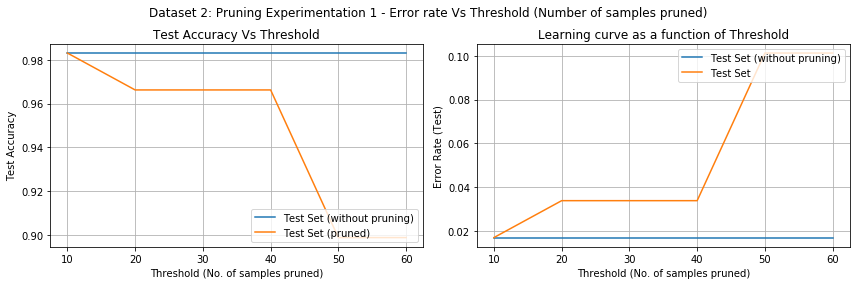

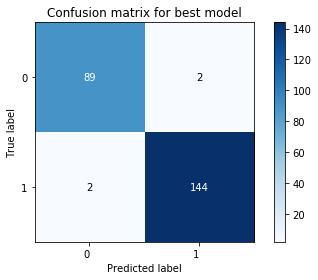

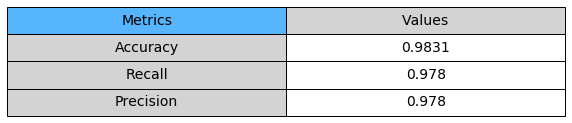

In [56]:
fig_dd2, ax_dd2 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

#ax_dd2[0].plot(prunes2, dd2_depth_acc_train_orig, label='Training Set (without pruning)')
ax_dd2[0].plot(prunes2, dd2_depth_acc_test_orig, label='Test Set (without pruning)')
#ax_dd2[0].plot(prunes2, dd2_depth_acc_train, label='Training Set (pruned)')
ax_dd2[0].plot(prunes2, dd2_depth_acc_test, label = 'Test Set (pruned)')
ax_dd2[0].set(xlabel='Threshold (No. of samples pruned)', ylabel='Test Accuracy', title='Test Accuracy Vs Threshold')
ax_dd2[0].grid()
ax_dd2[0].legend(loc='lower right')

#ax_dd2[1].plot(prunes2, dd2_depth_err_train_orig, label='Training Set (without pruning)')
ax_dd2[1].plot(prunes2, dd2_depth_err_test_orig, label='Test Set (without pruning)')
#ax_dd2[1].plot(prunes2, dd2_depth_err_train, label='Training Set (pruned)')
ax_dd2[1].plot(prunes2, dd2_depth_err_test, label = 'Test Set')
ax_dd2[1].set(xlabel='Threshold (No. of samples pruned)', ylabel='Error Rate (Test)', title='Learning curve as a function of Threshold')
ax_dd2[1].grid()
ax_dd2[1].legend(loc='upper right')

fig_dd2.tight_layout()
fig_dd2.suptitle('Dataset 2: Pruning Experimentation 1 - Error rate Vs Threshold (Number of samples pruned)')
fig_dd2.subplots_adjust(top=0.85)

import graphviz
from sklearn import tree
d2_model_ex2 = DT(d2_train_x, d2_train_y, 4, 0)
d2_model_ex2 = pruning_dt(d2_model_ex2, 0, 10)
cols = list(d2_train_x.columns)
dot_data = tree.export_graphviz(d2_model_ex2,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset2_DT_BestModel_pruning",view=True)

plot_confusion_matrix(d2_test_y, d2_model_ex2.predict(d2_test_x), classes=set(d2_train_y))

In [57]:
d2_depth_acc_train_orig = []
d2_depth_acc_test_orig = []
d2_depth_acc_train = []
d2_depth_acc_test = []
d2_depth_err_train_orig = []
d2_depth_err_test_orig = []
d2_depth_err_train = []
d2_depth_err_test = []
d2_depth = [1,2,3,4,5,6]

for d in d2_depth:
    d2_mod = DT(d2_train_x, d2_train_y, d, 0)
    d2_depth_acc_train_orig.append(d2_mod.score(d2_train_x, d2_train_y))
    d2_depth_err_train_orig.append(1-d2_mod.score(d2_train_x, d2_train_y))
    d2_depth_acc_test_orig.append(d2_mod.score(d2_test_x, d2_test_y))
    d2_depth_err_test_orig.append(1-d2_mod.score(d2_test_x, d2_test_y))
    
    d2_mod2 = pruning_dt(d2_mod, 0, 20)
    d2_depth_acc_train.append(d2_mod2.score(d2_train_x, d2_train_y))
    d2_depth_acc_test.append(d2_mod2.score(d2_test_x, d2_test_y))
    d2_depth_err_train.append(1-d2_mod2.score(d2_train_x, d2_train_y))
    d2_depth_err_test.append(1-d2_mod2.score(d2_test_x, d2_test_y))

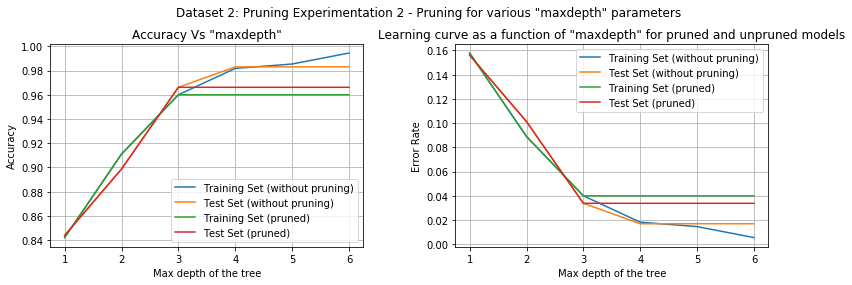

In [58]:
fig_d2, ax_d2 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))

ax_d2[0].plot(d2_depth, d2_depth_acc_train_orig, label='Training Set (without pruning)')
ax_d2[0].plot(d2_depth, d2_depth_acc_test_orig, label='Test Set (without pruning)')
ax_d2[0].plot(d2_depth, d2_depth_acc_train, label='Training Set (pruned)')
ax_d2[0].plot(d2_depth, d2_depth_acc_test, label = 'Test Set (pruned)')
ax_d2[0].set(xlabel='Max depth of the tree', ylabel='Accuracy', title='Accuracy Vs "maxdepth"')
ax_d2[0].grid()
ax_d2[0].legend(loc='lower right')

ax_d2[1].plot(d2_depth, d2_depth_err_train_orig, label='Training Set (without pruning)')
ax_d2[1].plot(d2_depth, d2_depth_err_test_orig, label='Test Set (without pruning)')
ax_d2[1].plot(d2_depth, d2_depth_err_train, label='Training Set (pruned)')
ax_d2[1].plot(d2_depth, d2_depth_err_test, label = 'Test Set (pruned)')
ax_d2[1].set(xlabel='Max depth of the tree', ylabel='Error Rate', title='Learning curve as a function of "maxdepth" for pruned and unpruned models')
ax_d2[1].grid()
ax_d2[1].legend(loc='upper right')

fig_d2.tight_layout()
fig_d2.suptitle('Dataset 2: Pruning Experimentation 2 - Pruning for various "maxdepth" parameters')
fig_d2.subplots_adjust(top=0.85)

**EXPERIMENT 3.3**  -   _Experimenting with Training Size_

**Dataset 1: Energy data**

In [59]:
d1_size = [0.6,0.7,0.8,0.9,1.0]
d1_ex3_train_acc = []
d1_ex3_test_acc = []
d1_ex3_train_err = []
d1_ex3_test_err = []

for s in d1_size:
        num = round(s*d1_train_x.shape[0])
        d1_ex3_model = DT(d1_train_x.loc[:num], d1_train_y.loc[:num], 16, 0)
        d1_ex3_train_acc.append(d1_ex3_model.score(d1_train_x, d1_train_y))
        d1_ex3_test_acc.append(d1_ex3_model.score(d1_test_x, d1_test_y))
        d1_ex3_train_err.append(1-d1_ex3_model.score(d1_train_x, d1_train_y))
        d1_ex3_test_err.append(1-d1_ex3_model.score(d1_test_x, d1_test_y))

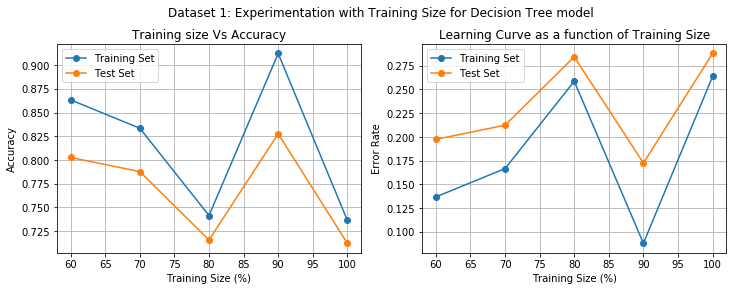

In [60]:
fig_ex3_d1, ax_ex3_d1 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))
x_ex3_d1 = [x*100 for x in d1_size]

ax_ex3_d1[0].plot(x_ex3_d1, d1_ex3_train_acc, 'o-', label='Training Set')
ax_ex3_d1[0].plot(x_ex3_d1, d1_ex3_test_acc, 'o-', label='Test Set')
ax_ex3_d1[0].set(xlabel='Training Size (%)', ylabel='Accuracy', title='Training size Vs Accuracy')
ax_ex3_d1[0].grid()
ax_ex3_d1[0].legend(loc='best')

ax_ex3_d1[1].plot(x_ex3_d1, d1_ex3_train_err, 'o-', label='Training Set')
ax_ex3_d1[1].plot(x_ex3_d1, d1_ex3_test_err, 'o-', label='Test Set')
ax_ex3_d1[1].set(xlabel='Training Size (%)', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_ex3_d1[1].grid()
ax_ex3_d1[1].legend(loc='best')

fig_ex3_d1.suptitle('Dataset 1: Experimentation with Training Size for Decision Tree model')
fig_ex3_d1.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f4968748d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f496907d30>)

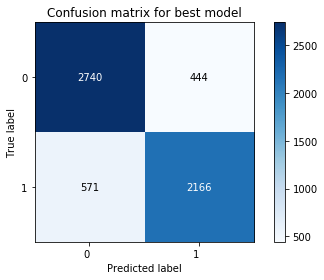

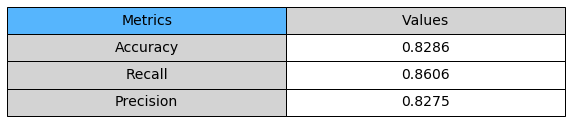

In [61]:
import graphviz
from sklearn import tree
num331 = round(0.90*d1_train_x.shape[0])+1
d1_ex33_model = DT(d1_train_x.loc[:num331], d1_train_y.loc[:num331], 16, 0)
cols = list(d1_train_x.columns)
dot_data = tree.export_graphviz(d1_ex33_model,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset1_DT_BestModel_trainSize",view=True)

plot_confusion_matrix(d1_test_y, d1_ex33_model.predict(d1_test_x), classes=set(d1_train_y))

**Dataset 2: Audit Data**

In [62]:
d2_size = [0.6,0.7,0.8,0.9,1.0]
d2_ex3_train_acc = []
d2_ex3_test_acc = []
d2_ex3_train_err = []
d2_ex3_test_err = []

for ss in d2_size:
        num2 = round(ss*d2_train_x.shape[0])+1
        d2_ex3_model = DT(d2_train_x.loc[:num2], d2_train_y.loc[:num2], 4, 0)
        d2_ex3_train_acc.append(d2_ex3_model.score(d2_train_x, d2_train_y))
        d2_ex3_test_acc.append(d2_ex3_model.score(d2_test_x, d2_test_y))
        d2_ex3_train_err.append(1-d2_ex3_model.score(d2_train_x, d2_train_y))
        d2_ex3_test_err.append(1-d2_ex3_model.score(d2_test_x, d2_test_y))

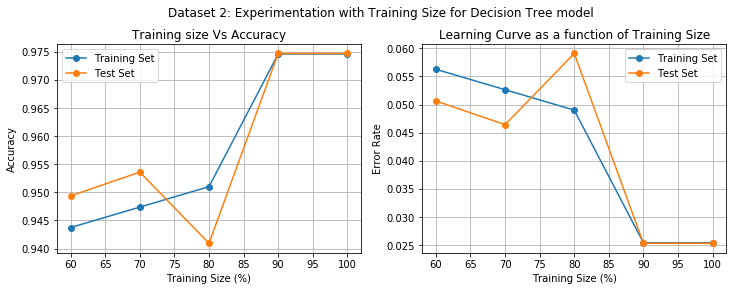

In [63]:
fig_ex3_d2, ax_ex3_d2 = plt.subplots(ncols=2,nrows=1,figsize=(12,4))
x_ex3_d2 = [x*100 for x in d2_size]

ax_ex3_d2[0].plot(x_ex3_d2, d2_ex3_train_acc, 'o-', label='Training Set')
ax_ex3_d2[0].plot(x_ex3_d2, d2_ex3_test_acc, 'o-', label='Test Set')
ax_ex3_d2[0].set(xlabel='Training Size (%)', ylabel='Accuracy', title='Training size Vs Accuracy')
ax_ex3_d2[0].grid()
ax_ex3_d2[0].legend(loc='best')

ax_ex3_d2[1].plot(x_ex3_d2, d2_ex3_train_err, 'o-', label='Training Set')
ax_ex3_d2[1].plot(x_ex3_d2, d2_ex3_test_err, 'o-', label='Test Set')
ax_ex3_d2[1].set(xlabel='Training Size (%)', ylabel='Error Rate', title='Learning Curve as a function of Training Size')
ax_ex3_d2[1].grid()
ax_ex3_d2[1].legend(loc='best')

fig_ex3_d2.suptitle('Dataset 2: Experimentation with Training Size for Decision Tree model')
fig_ex3_d2.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f496a1dac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f496af25f8>)

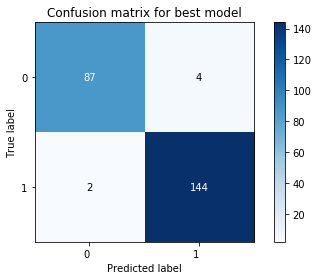

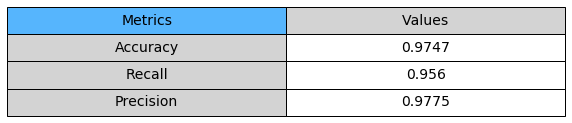

In [64]:
import graphviz
from sklearn import tree
num33 = round(0.90*d2_train_x.shape[0])+1
d2_ex33_model = DT(d2_train_x.loc[:num33], d2_train_y.loc[:num33], 4, 0)
cols = list(d2_train_x.columns)
dot_data = tree.export_graphviz(d2_ex33_model,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset2_DT_BestModel_trainSize",view=True)

plot_confusion_matrix(d2_test_y, d2_ex33_model.predict(d2_test_x), classes=set(d2_train_y))

**Implementation of Boosted version of Decision Tree**

**EXPERIMENT 4.1**  -   _Experimenting with 'No. of Boosting stages (estimators)' parameter_

**Dataset 1: Energy data**

In [65]:
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

def boost_dt(x, y, num_estimators, min_samples_in_leaf, maxdepths):
    gb_model = GradientBoostingClassifier(max_depth=maxdepths, n_estimators=num_estimators, min_samples_leaf=min_samples_in_leaf, random_state=random_num)
    gb_model.fit(x,y)
    return(gb_model)

In [66]:
gb_d1_train_acc = []
gb_d1_test_acc = []
gb_d1_train_err = []
gb_d1_test_err = []

n_forests = [10,20,30,40,50]
for n in n_forests:
    gb_mod = boost_dt(d1_train_x, d1_train_y, n, 1, 10)
    gb_d1_train_acc.append(gb_mod.score(d1_train_x, d1_train_y))
    gb_d1_test_acc.append(gb_mod.score(d1_test_x, d1_test_y))
    
    gb_d1_train_err.append(1-gb_mod.score(d1_train_x, d1_train_y))
    gb_d1_test_err.append(1-gb_mod.score(d1_test_x, d1_test_y))

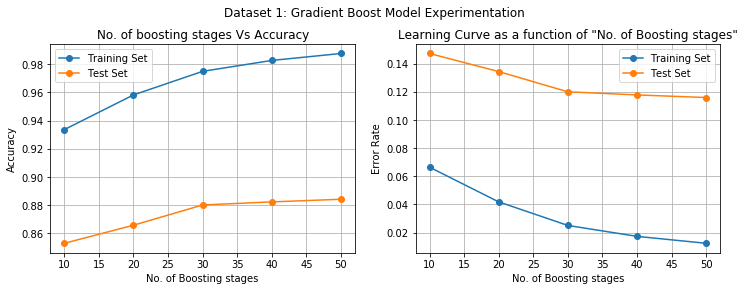

In [67]:
fig_gb1, ax_gb1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_gb1[0].plot(n_forests, gb_d1_train_acc,'o-', label='Training Set')
ax_gb1[0].plot(n_forests, gb_d1_test_acc,'o-', label='Test Set')
ax_gb1[0].set(xlabel='No. of Boosting stages', ylabel='Accuracy', title='No. of boosting stages Vs Accuracy')
ax_gb1[0].grid()
ax_gb1[0].legend(loc='best')

ax_gb1[1].plot(n_forests, gb_d1_train_err,'o-', label='Training Set')
ax_gb1[1].plot(n_forests, gb_d1_test_err,'o-', label='Test Set')
ax_gb1[1].set(xlabel='No. of Boosting stages', ylabel='Error Rate', title='Learning Curve as a function of "No. of Boosting stages"')
ax_gb1[1].grid()
ax_gb1[1].legend(loc='best')

fig_gb1.suptitle('Dataset 1: Gradient Boost Model Experimentation')
fig_gb1.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f496cf2e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f496d6db70>)

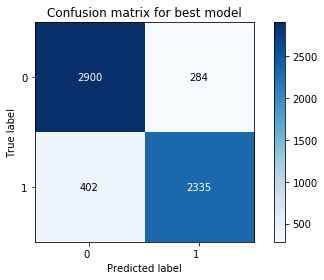

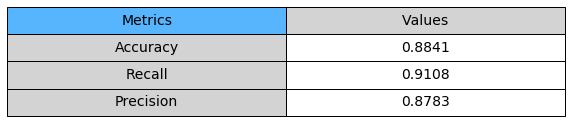

In [68]:
import graphviz
from sklearn import tree
d1_ex41_model = boost_dt(d1_train_x, d1_train_y, 50, 1, 10)
d1_ex41_tree = d1_ex41_model.estimators_[49,0]
cols = list(d1_train_x.columns)
dot_data = tree.export_graphviz(d1_ex41_tree,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset1_GB_BestModel_boosts",view=True)

plot_confusion_matrix(d1_test_y, d1_ex41_model.predict(d1_test_x), classes=set(d1_train_y))

**Dataset 2: Audit data**

In [69]:
gb_d2_train_acc = []
gb_d2_test_acc = []
gb_d2_train_err = []
gb_d2_test_err = []

boosts_n = [10,20,30,40,50]
for n in boosts_n:
    gb_mod2 = boost_dt(d2_train_x, d2_train_y, n, 1, 3)
    gb_d2_train_acc.append(gb_mod2.score(d2_train_x, d2_train_y))
    gb_d2_test_acc.append(gb_mod2.score(d2_test_x, d2_test_y))
    
    gb_d2_train_err.append(1-gb_mod2.score(d2_train_x, d2_train_y))
    gb_d2_test_err.append(1-gb_mod2.score(d2_test_x, d2_test_y))

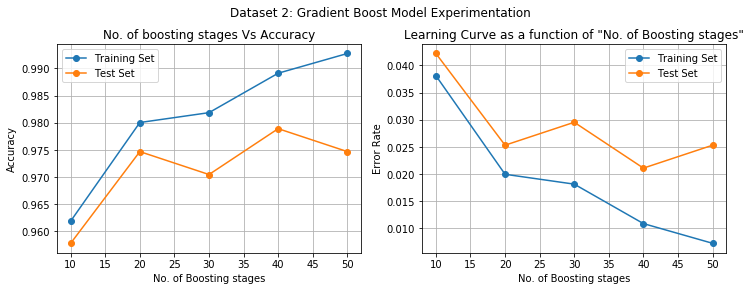

In [70]:
fig_gb2, ax_gb2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax_gb2[0].plot(boosts_n, gb_d2_train_acc,'o-', label='Training Set')
ax_gb2[0].plot(boosts_n, gb_d2_test_acc,'o-', label='Test Set')
ax_gb2[0].set(xlabel='No. of Boosting stages', ylabel='Accuracy', title='No. of boosting stages Vs Accuracy')
ax_gb2[0].grid()
ax_gb2[0].legend(loc='best')

ax_gb2[1].plot(boosts_n, gb_d2_train_err,'o-', label='Training Set')
ax_gb2[1].plot(boosts_n, gb_d2_test_err,'o-', label='Test Set')
ax_gb2[1].set(xlabel='No. of Boosting stages', ylabel='Error Rate', title='Learning Curve as a function of "No. of Boosting stages"')
ax_gb2[1].grid()
ax_gb2[1].legend(loc='best')

fig_gb2.suptitle('Dataset 2: Gradient Boost Model Experimentation')
fig_gb2.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f496eb2e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f496f62c18>)

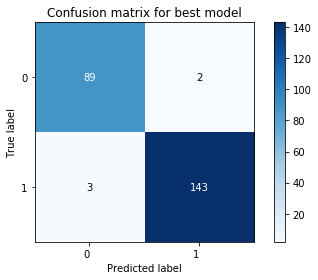

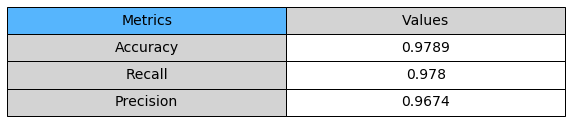

In [71]:
import graphviz
from sklearn import tree
d2_ex41_model = boost_dt(d2_train_x, d2_train_y, 40, 1, 3)
d2_ex41_tree = d2_ex41_model.estimators_[39,0]
cols = list(d2_train_x.columns)
dot_data = tree.export_graphviz(d2_ex41_tree,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset2_GB_BestModel_boosts",view=True)

plot_confusion_matrix(d2_test_y, d2_ex41_model.predict(d2_test_x), classes=set(d2_train_y))

**EXPERIMENT 4.2**  -   _Experimenting with PRUNING_

**Dataset 1: Energy data**

In [72]:
min_num_samples = range(1,10)
num_of_boosts = 50

gb2_d1_train_acc = []
gb2_d1_test_acc = []
gb2_d1_train_err = []
gb2_d1_test_err = []

gb2_d1_train_acc_orig = []
gb2_d1_test_acc_orig = []
gb2_d1_train_err_orig = []
gb2_d1_test_err_orig = []


for m in min_num_samples:
    gb2_mod_orig = boost_dt(d1_train_x, d1_train_y, num_of_boosts, 1, 10)
    gb2_d1_train_acc_orig.append(gb2_mod_orig.score(d1_train_x, d1_train_y))
    gb2_d1_test_acc_orig.append(gb2_mod_orig.score(d1_test_x, d1_test_y))  
    gb2_d1_train_err_orig.append(1-gb2_mod_orig.score(d1_train_x, d1_train_y))
    gb2_d1_test_err_orig.append(1-gb2_mod_orig.score(d1_test_x, d1_test_y))
    
    gb2_mod = boost_dt(d1_train_x, d1_train_y, num_of_boosts, m, 10)
    gb2_d1_train_acc.append(gb2_mod.score(d1_train_x, d1_train_y))
    gb2_d1_test_acc.append(gb2_mod.score(d1_test_x, d1_test_y))   
    gb2_d1_train_err.append(1-gb2_mod.score(d1_train_x, d1_train_y))
    gb2_d1_test_err.append(1-gb2_mod.score(d1_test_x, d1_test_y))

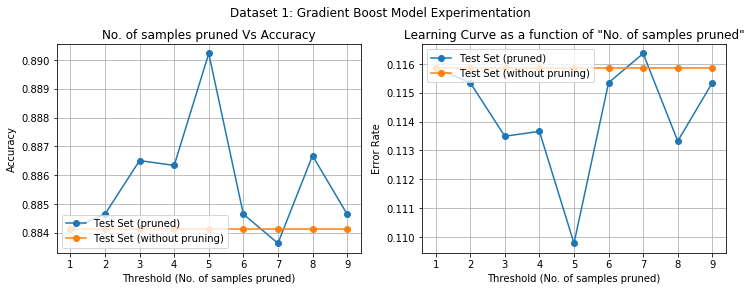

In [73]:
fig_gb2, ax_gb2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

#ax_gb2[0].plot(min_num_samples, gb2_d1_train_acc, label='Training Set (pruned)')
ax_gb2[0].plot(min_num_samples, gb2_d1_test_acc, 'o-', label='Test Set (pruned)')
#ax_gb2[0].plot(min_num_samples, gb2_d1_train_acc_orig, label='Training Set (without pruning)')
ax_gb2[0].plot(min_num_samples, gb2_d1_test_acc_orig, 'o-', label='Test Set (without pruning)')
ax_gb2[0].set(xlabel='Threshold (No. of samples pruned)', ylabel='Accuracy', title='No. of samples pruned Vs Accuracy')
ax_gb2[0].grid()
ax_gb2[0].legend(loc='lower left')

#ax_gb2[1].plot(min_num_samples, gb2_d1_train_err, label='Training Set (pruned)')
ax_gb2[1].plot(min_num_samples, gb2_d1_test_err, 'o-', label='Test Set (pruned)')
#ax_gb2[1].plot(min_num_samples, gb2_d1_train_err_orig, label='Training Set (without pruning)')
ax_gb2[1].plot(min_num_samples, gb2_d1_test_err_orig, 'o-', label='Test Set (without pruning)')
ax_gb2[1].set(xlabel='Threshold (No. of samples pruned)', ylabel='Error Rate', title='Learning Curve as a function of "No. of samples pruned"')
ax_gb2[1].grid()
ax_gb2[1].legend(loc='upper left')

fig_gb2.suptitle('Dataset 1: Gradient Boost Model Experimentation')
fig_gb2.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f4970dcd68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f497157b38>)

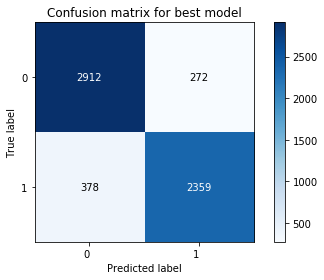

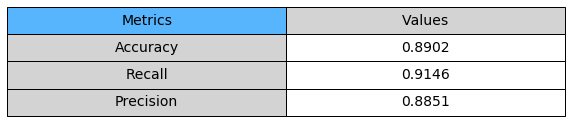

In [74]:
import graphviz
from sklearn import tree
d1_ex42_model = boost_dt(d1_train_x, d1_train_y, 50, 5, 10)
d1_ex42_tree = d1_ex42_model.estimators_[49,0]
cols = list(d1_train_x.columns)
dot_data = tree.export_graphviz(d1_ex42_tree,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset1_GB_BestModel_pruning",view=True)

plot_confusion_matrix(d1_test_y, d1_ex42_model.predict(d1_test_x), classes=set(d1_train_y))

**Dataset 2: Audit data**

In [75]:
min_num_samples = range(1,10)
num_of_boosts2 = 50

gb2_d2_train_acc = []
gb2_d2_test_acc = []
gb2_d2_train_err = []
gb2_d2_test_err = []

gb2_d2_train_acc_orig = []
gb2_d2_test_acc_orig = []
gb2_d2_train_err_orig = []
gb2_d2_test_err_orig = []

for m in min_num_samples:
    gb2_mod_orig = boost_dt(d2_train_x, d2_train_y, num_of_boosts2, 1, 3)
    gb2_d2_train_acc_orig.append(gb2_mod_orig.score(d2_train_x, d2_train_y))
    gb2_d2_test_acc_orig.append(gb2_mod_orig.score(d2_test_x, d2_test_y))  
    gb2_d2_train_err_orig.append(1-gb2_mod_orig.score(d2_train_x, d2_train_y))
    gb2_d2_test_err_orig.append(1-gb2_mod_orig.score(d2_test_x, d2_test_y))
    
    gb2_mod = boost_dt(d2_train_x, d2_train_y, num_of_boosts2, m, 3)
    gb2_d2_train_acc.append(gb2_mod.score(d2_train_x, d2_train_y))
    gb2_d2_test_acc.append(gb2_mod.score(d2_test_x, d2_test_y))   
    gb2_d2_train_err.append(1-gb2_mod.score(d2_train_x, d2_train_y))
    gb2_d2_test_err.append(1-gb2_mod.score(d2_test_x, d2_test_y))

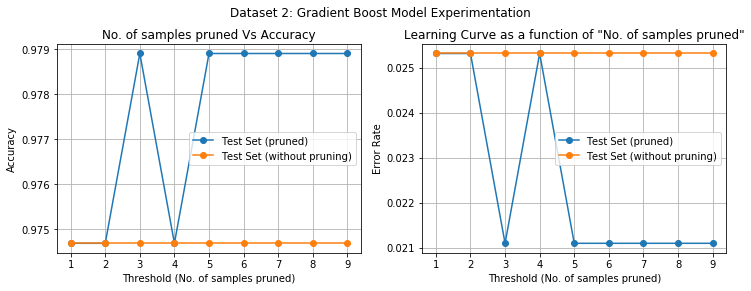

In [76]:
fig1_gb2, ax1_gb2 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

#ax1_gb2[0].plot(min_num_samples, gb2_d2_train_acc, label='Training Set (pruned)')
ax1_gb2[0].plot(min_num_samples, gb2_d2_test_acc, 'o-', label='Test Set (pruned)')
#ax1_gb2[0].plot(min_num_samples, gb2_d2_train_acc_orig, label='Training Set (without pruning)')
ax1_gb2[0].plot(min_num_samples, gb2_d2_test_acc_orig, 'o-', label='Test Set (without pruning)')
ax1_gb2[0].set(xlabel='Threshold (No. of samples pruned)', ylabel='Accuracy', title='No. of samples pruned Vs Accuracy')
ax1_gb2[0].grid()
ax1_gb2[0].legend(loc='best')

#ax1_gb2[1].plot(min_num_samples, gb2_d2_train_err, label='Training Set (pruned)')
ax1_gb2[1].plot(min_num_samples, gb2_d2_test_err, 'o-', label='Test Set (pruned)')
#ax1_gb2[1].plot(min_num_samples, gb2_d2_train_err_orig, label='Training Set (without pruning)')
ax1_gb2[1].plot(min_num_samples, gb2_d2_test_err_orig, 'o-', label='Test Set (without pruning)')
ax1_gb2[1].set(xlabel='Threshold (No. of samples pruned)', ylabel='Error Rate', title='Learning Curve as a function of "No. of samples pruned"')
ax1_gb2[1].grid()
ax1_gb2[1].legend(loc='best')

fig1_gb2.suptitle('Dataset 2: Gradient Boost Model Experimentation')
fig1_gb2.subplots_adjust(top=0.85)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f4972b87b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f497337748>)

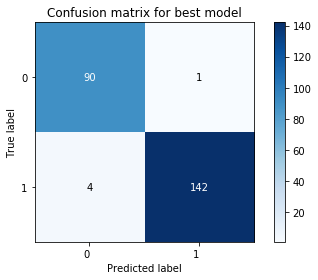

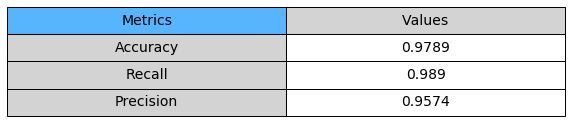

In [77]:
import graphviz
from sklearn import tree
d2_ex42_model = boost_dt(d2_train_x, d2_train_y, 50, 5, 3)
d2_ex42_tree = d2_ex42_model.estimators_[49,0]
cols = list(d2_train_x.columns)
dot_data = tree.export_graphviz(d2_ex42_tree,out_file=None,feature_names=cols,class_names=True)
graph = graphviz.Source(dot_data)
## Uncomment here
#graph.render("Dataset2_GB_BestModel_pruning",view=True)

plot_confusion_matrix(d2_test_y, d2_ex42_model.predict(d2_test_x), classes=set(d2_train_y))

**Implementation of Cross Validation for both datasets**

In [78]:
# Cross Validation function
from sklearn.model_selection import cross_validate

def CV(model,x,Y,folds):
    cv_results = cross_validate(model,x,Y,cv=folds, return_train_score = True)
    return(cv_results)

**Dataset 1: Energy data**

In [79]:
folds = 5
d1_svm = svm_model(svm_train_x, svm_train_y, 'poly', 1, 3, 'scale', toler)
d1_cv_svm = CV(d1_svm, svm_train_x, svm_train_y, folds)

d1_dt = DT(d1_train_x, d1_train_y, 16, 0)
d1_cv_dt = CV(d1_dt, d1_train_x, d1_train_y, folds)

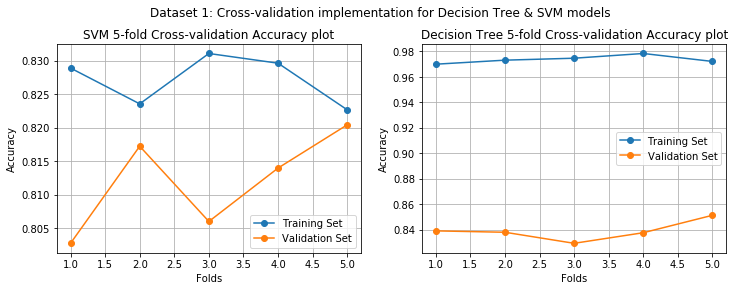

In [80]:
fig_cv1, ax_cv1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
cv_x = range(1,6)

ax_cv1[0].plot(cv_x, d1_cv_svm['train_score'], 'o-',label='Training Set')
ax_cv1[0].plot(cv_x, d1_cv_svm['test_score'], 'o-', label='Validation Set')
ax_cv1[0].set(xlabel='Folds',ylabel='Accuracy',title='SVM 5-fold Cross-validation Accuracy plot')
ax_cv1[0].grid()
ax_cv1[0].legend(loc='best')

ax_cv1[1].plot(cv_x, d1_cv_dt['train_score'], 'o-', label='Training Set')
ax_cv1[1].plot(cv_x, d1_cv_dt['test_score'], 'o-', label='Validation Set')
ax_cv1[1].set(xlabel='Folds',ylabel='Accuracy',title='Decision Tree 5-fold Cross-validation Accuracy plot')
ax_cv1[1].grid()
ax_cv1[1].legend(loc='best')

fig_cv1.suptitle('Dataset 1: Cross-validation implementation for Decision Tree & SVM models')
fig_cv1.subplots_adjust(top=0.85)

**Dataset 2: Audit Data**

In [81]:
folds = 5
d2_svm = svm_model(x2_train, y2_train, 'poly', 1, 3, 'scale', toler)
d2_cv_svm = CV(d2_svm, x2_train, y2_train, folds)

d2_dt = DT(x2_train, y2_train, 16, 0)
d2_cv_dt = CV(d2_dt, x2_train, y2_train, folds)

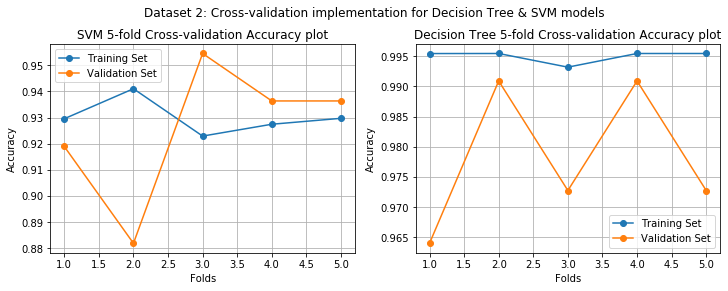

In [82]:
fig_cv1, ax_cv1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
cv_x = range(1,6)

ax_cv1[0].plot(cv_x, d2_cv_svm['train_score'], 'o-',label='Training Set')
ax_cv1[0].plot(cv_x, d2_cv_svm['test_score'], 'o-', label='Validation Set')
ax_cv1[0].set(xlabel='Folds',ylabel='Accuracy',title='SVM 5-fold Cross-validation Accuracy plot')
ax_cv1[0].grid()
ax_cv1[0].legend(loc='best')

ax_cv1[1].plot(cv_x, d2_cv_dt['train_score'], 'o-', label='Training Set')
ax_cv1[1].plot(cv_x, d2_cv_dt['test_score'], 'o-', label='Validation Set')
ax_cv1[1].set(xlabel='Folds',ylabel='Accuracy',title='Decision Tree 5-fold Cross-validation Accuracy plot')
ax_cv1[1].grid()
ax_cv1[1].legend(loc='best')

fig_cv1.suptitle('Dataset 2: Cross-validation implementation for Decision Tree & SVM models')
fig_cv1.subplots_adjust(top=0.85)